# Metabolomics Data Analysis - FT-ICR-MS-Lisboa

This notebook provides a template for standard metabolomics data analysis whether or not you already annoted your data with names and/or chemical formulas using Metaboscape.

This allows you to annotate, treat, see common and exclusive metabolites, do multivariate unsupervised and supervised statistical analysis, do univariate statistical analysis, produce Van Krevelen diagrams, Kendrick Mass Defect plots and chemical composition series. It also has compound finders that allow you to search for specific compounds using their names, chemical formulas, _m/z_'s or neutral masses.

A wide variety of data pre-treatments is provided, but you don't have to use all of them. Some of the functions may seem intimidating, but they are easily costumizable and instructions to do that are provided.

**Warning**: Reading files is very dependent on the format of the file, you'll have to see and adapt that part and not just press run all on the notebook.

**Please inform us if you think something would be useful here that is not here already, other things you would like to be able to do or if something breaks spectacularly. As with 1.0 version, 2.0 version is likely to have some minor bugs and errors for specific cases that we will correct in future versions.**

### References

A lot of materials (Python functions) from the following paper was used for this pipeline (furthermore, BinSim analysis as described in the paper is also done here in the notebook):

- Traquete, F.; Luz, J.; Cordeiro, C.; Sousa Silva, M.; Ferreira, A.E.N. Binary Simplification as an Effective Tool in Metabolomics Data Analysis. _Metabolites_ 2021, 11, doi:10.3390/metabo11110788.

Apart from this, 3 specific Python libraries that are used should also be mentioned:

- Metabolinks (our in-house Python library) - https://zenodo.org/record/5336951#.Y-TbpnbP1D8.
- UpSetPlot (to make the UpSetPlots only) - https://pypi.org/project/UpSetPlot/0.8.0/.
- Pyvenn (to make the Venn Diagrams only) - https://github.com/tctianchi/pyvenn.

Finally, the most common Python libraries that are used here are pandas, numpy, scipy, scikit-learn, matplotlib and seaborn.

# Table of Contents <a class="anchor" id="toc"></a>

- **[Step 0: Installing Metabolinks and other packages](#step-0)**
- **[Step 1: Upload your data](#step-1)**
  - **[Step 1.1: Define your groups and see data characterization](#step-1.1)**
  - **[Step 1.2: Annotate with Database(s)](#step-1.2)**
  - **[Step 1.3: De-duplicating annotations](#step-1.3)**  
- **[Step 2: Basic processing and pre-treatment](#step-2)**
- **[Step 3: Find Common and Exclusive metabolites between the groups](#step-3)**
- **[Step 4: Unsupervised Statistical Analysis (PCA and HCA)](#step-4)**
- **[Step 5: Supervised Statistical Analysis (Random Forest and PLS-DA)](#step-5)**
  - **[Step 5.1: Random Forest](#step-5.1)**
  - **[Step 5.2: PLS-DA (Partial Least Squares - Discriminant Analysis)](#step-5.2)**
- **[Step 6: Univariate Analysis and Fold-Change Analysis](#step-6)**
- **[Step 7: Make Van Krevelen Diagrams, Kendrick Mass Defect Plots and Chemical Composition series for your samples](#step-7)**
- **[Step 8: BinSim Specific Analysis](#step-8)**
- **[Step 9: Find Specific Compounds](#step-9)**

### Some common needed imports

In [1]:
import pandas as pd
import numpy as np

import re

from tqdm import tqdm

import itertools

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import sklearn.ensemble as skensemble
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import TwoSlopeNorm

import seaborn as sns

import upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

# Our Python package
import metabolinks as mtl
import metabolinks.transformations as transf

# elips.py file (has to be in the same folder)
from elips import plot_confidence_ellipse
# venn.py file
import venn as venn
# metanalysis_standard.py file
import metanalysis_standard as metsta
# multianalysis.py file (has to be in the same folder)
from multianalysis import p_adjust_bh, compute_df_with_PCs, fit_PLSDA_model, _calculate_vips, _generate_y_PLSDA

# Step 0: Installing Metabolinks and other packages<a class="anchor" id="step-0"></a>

**Back to [Table of Contents](#toc)**

**Metabolinks and UpSetPlot**

- Open 'Command Line' or 'Linha de comandos' on your pc.
- Run the line 'pip install metabolinks'.
- Run the line 'pip install UpSetPlot'.
- Restart jupyter.

**pyvenn**

- Go to https://github.com/tctianchi/pyvenn/blob/master/venn.py.
- Over 'Raw' (see where 'Watch' is on the upper left and move look down), click 'Save link as...'.
- Save it on the same folder you have the rest of the files.


# Step 1: Upload your data <a class="anchor" id="step-1"></a>

**Back to [Table of Contents](#toc)**

(**Warning**: Depending on the format of your file, this can be different!)

This is made for csv and excel files extracted from MetaboScape. Default is csv, excel is last block of text (remove # if you want to use it).

What does this do?
- Produces a pandas DataFrame with your spectral data
- Renames the columns to obtain "clean" sample names (if necessary)
- Replaces 0 values with numpy null objects (nan). This is necessary to know how many metabolites each sample has and to allow further data processing.

In [2]:
# For .csv from MetaboScape (they still might have some differences, for example in the headers)
# Example

filename = '5yeasts_notnorm.csv' # Name of your file
file = pd.read_csv(filename)
file.insert(1, 'Neutral Mass', file['Bucket label'].str.replace('Da', '').astype('float')) #important for database match
file = file.set_index('Bucket label')

# Replaces zeros with numpy nans. Essential for data processing
file = file.replace({0:np.nan})

# Samples names frequently have 00000. Use this code to make them 'cleaner'. If not needed just skip this part (use #)
def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))
file.columns = [renamer(i) for i in file.columns]

# Example with an Excel file - tricky with different headers
#filename = '06-03_Fingerprint Methods.xlsx' # Name of your file
#file = pd.read_excel(filename)
#file = file.set_index('Bucket label')

In [3]:
# Identify sample columns
sample_cols = []
for c in file.columns:
    if c not in ['Neutral Mass', 'm/z', 'Formula', 'Name']:
        sample_cols.append(c)
print(sample_cols)

['BY0_1', 'BY0_2', 'BY0_3', 'GRE3_1', 'GRE3_2', 'GRE3_3', 'ENO1_1', 'ENO1_2', 'ENO1_3', 'dGLO1_1', 'dGLO1_2', 'dGLO1_3', 'GLO2_1', 'GLO2_2', 'GLO2_3']


In [4]:
file

,Neutral Mass,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,,
307.0838178877 Da,307.083818,308.09110,Glutathione,C10H17N3O6S,391042880.0,398003680.0,399481952.0,270906400.0,271023520.0,274854272.0,2.552767e+08,251610656.0,251024624.0,283822048.0,285664416.0,295673952.0,287722656.0,287749600.0,290416512.0
555.2692975341 Da,555.269298,556.27657,Enkephalin L,C28H37N5O7,111270160.0,110423984.0,111225424.0,92849040.0,94888320.0,94514272.0,1.506205e+08,148516304.0,150645840.0,202869216.0,205537504.0,209370176.0,421969440.0,416559200.0,419548864.0
624.0873082632 Da,624.087308,625.09457,NaN,C14H28N10O10S4,130088936.0,127133608.0,131208568.0,130682664.0,130844488.0,130896568.0,1.366125e+08,134972800.0,135922432.0,130259064.0,128839264.0,132857032.0,131498984.0,131380096.0,131334040.0
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,106187168.0,109233816.0,111553216.0,104352720.0,107277600.0,109619152.0,3.127691e+07,31337604.0,31644646.0,39904768.0,40704944.0,40875840.0,56428384.0,57348836.0,58999288.0
257.1028750516 Da,257.102875,258.11016,Glycerophosphocholine,C8H20NO6P,54234476.0,53720908.0,55826148.0,46503348.0,44828256.0,46361588.0,7.246554e+07,70376640.0,68912816.0,58269456.0,56775068.0,58019620.0,59549848.0,60346920.0,61914296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029.1188620710 Da,2029.118862,2030.12614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.309092e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
532.8123880500 Da,532.812388,533.81966,NaN,C9H4N5O8PS6,NaN,NaN,NaN,NaN,NaN,NaN,5.308958e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069.9969559833 Da,1069.996956,1071.00423,NaN,C37H18N16O16S4,NaN,NaN,NaN,NaN,NaN,NaN,5.308951e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Initial Filtering of the data if you want to do it. This function is explained and used in more detail after in **step 2**.

In [5]:
min_samples_feature_appear = 2 # Select the minimum number of samples a feature must appear to be kept in the dataset

meta_cols = [i for i in file.columns if i not in sample_cols]
temp = metsta.basic_feat_filtering(file[sample_cols].T, target=None,
                            filt_method='total_samples', # Method
                            filt_kw=min_samples_feature_appear) # Make a sample have to appear
file = pd.concat((file[meta_cols].reindex(temp.columns), temp.T), axis=1)

In [6]:
file

,Neutral Mass,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,,
307.0838178877 Da,307.083818,308.09110,Glutathione,C10H17N3O6S,391042880.0,398003680.0,399481952.0,270906400.0,271023520.0,274854272.0,2.552767e+08,2.516107e+08,2.510246e+08,283822048.0,285664416.0,2.956740e+08,2.877227e+08,2.877496e+08,290416512.0
555.2692975341 Da,555.269298,556.27657,Enkephalin L,C28H37N5O7,111270160.0,110423984.0,111225424.0,92849040.0,94888320.0,94514272.0,1.506205e+08,1.485163e+08,1.506458e+08,202869216.0,205537504.0,2.093702e+08,4.219694e+08,4.165592e+08,419548864.0
624.0873082632 Da,624.087308,625.09457,NaN,C14H28N10O10S4,130088936.0,127133608.0,131208568.0,130682664.0,130844488.0,130896568.0,1.366125e+08,1.349728e+08,1.359224e+08,130259064.0,128839264.0,1.328570e+08,1.314990e+08,1.313801e+08,131334040.0
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,106187168.0,109233816.0,111553216.0,104352720.0,107277600.0,109619152.0,3.127691e+07,3.133760e+07,3.164465e+07,39904768.0,40704944.0,4.087584e+07,5.642838e+07,5.734884e+07,58999288.0
257.1028750516 Da,257.102875,258.11016,Glycerophosphocholine,C8H20NO6P,54234476.0,53720908.0,55826148.0,46503348.0,44828256.0,46361588.0,7.246554e+07,7.037664e+07,6.891282e+07,58269456.0,56775068.0,5.801962e+07,5.954985e+07,6.034692e+07,61914296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892.5313342202 Da,892.531334,893.53861,NaN,C48H72N6O10,NaN,NaN,NaN,548196.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.482588e+05,NaN
847.0028787316 Da,847.002879,848.01016,NaN,C22H6N23O12PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.498614e+05,NaN,NaN,NaN,5.464487e+05,NaN,NaN,NaN
535.6351204857 Da,535.635120,536.64240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.514251e+05,NaN,NaN,NaN,NaN,NaN,5.424146e+05,NaN,NaN


# Step 1.1: Define your groups and see data characterization <a class="anchor" id="step-1.1"></a>

**Back to [Table of Contents](#toc)**

Here, we will define our groups (yeast strains in our example), so that we can obtain merged dataframes for each one of them and define colours to help us visualise them in later figures.

In [7]:
# Insert your groups in the "target" list by the exact order in which they appear in the dataframe.
# Remember that each group must appear as many times as there are samples belonging to that group
target = ['WT', 'WT', 'WT', 'dGRE3', 'dGRE3', 'dGRE3', 'dENO1', 'dENO1', 'dENO1', 'dGLO1', 'dGLO1', 'dGLO1',
          'dGLO2', 'dGLO2', 'dGLO2']
# See if the classes are those that you want
classes = list(pd.unique(target))
classes

['WT', 'dGRE3', 'dENO1', 'dGLO1', 'dGLO2']

#### Colors for plots to ensure consistency

Play around with colours to get the ones you want. 

- Colormaps like the tab10 used below: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- List of names of individual colours: https://matplotlib.org/stable/gallery/color/named_colors.html

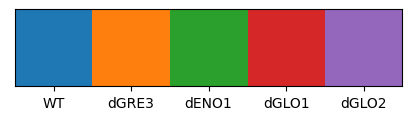

In [8]:
# customize label colors

colours = sns.color_palette('tab10', 10) # Only room for 10 classes in this case, choose your colours
#colours = ('coral', 'turquoise', 'gold', 'indigo', 'lightgreen') # Example for using named colours
ordered_labels = classes # Put the classes, you can choose the order

label_colours = {lbl: c for lbl, c in zip(ordered_labels, colours)}
sample_colours = [label_colours[lbl] for lbl in target]

# See the colours for each class
sns.palplot(label_colours.values())
new_ticks = plt.xticks(range(len(ordered_labels)), ordered_labels)

In [9]:
# See data characterization
data_characteristics = metsta.characterize_data(file[sample_cols].T, target=target)
data_characteristics

{'Dataset': 'dataset',
 '# samples': 15,
 '# features': 1973,
 'feature value average (std)': '3104510.9799207044 (16086934.671045555)',
 'feature value ranges': '(532527.9375 - 421969440.0)',
 'feature value median': 874946.25,
 '# classes': 5,
 'samples / class': 3.0}

**Run this cell instead of the pre-treatment if you have already done it in MetaboScape**

In [10]:
# If you have already done everything in Metaboscape, run this to just remove the reference feature
# Exact name of the reference feature Leucine Enkephalin on this dataset
# A string in this case
print(file.index[1])
# ref_feat_lbl = '555.2692975341 Da'
# file = file.drop(index=ref_feat_lbl)

555.2692975341 Da


# Step 1.2: Annotate with Database(s) <a class="anchor" id="step-1.2"></a>

**Back to [Table of Contents](#toc)**

This is where you upload your database(s) to annotate your experimental dataset. 

Make sure that your file contains at least the following columns:
- One with the databases accession label. This will serve as the index. In case you are a masochist and have opted to create your own database, make sure you give each compound an accession label (eg. DB0001, DB0002, DB0003, etc.)
- One with the compounds' monoisotopic molecular masses (if possible, make sure that they are neutral masses)
- One with the compounds' names
- One with the compounds' chemical formulas

If for some reason you don't have one of these columns, please tell us as some things will need to be tweaked a little to accomodate for your situation.

For the sake of simplicity, the lists of compound IDs, names and formulas will be placed in different columns. Just remember that they will be added by the same order, so the first ID in the IDs column corresponds to the first name in the names column and the first formula in the formulas column.

**See metanalysis_standard.py for functions about annotation**

In [11]:
dbs = { # How you want the database to be called in the data: 'HMDB', ' PCY', 'DBK'
    'HMDB': {'File': 'hmdb_complete.xlsx', # The name of each file
             'Index_name': 'accession', # The name of the index in each database
             'Name_col': 'name', # The name column in each database
             'Mass_col': 'monisotopic_molecular_weight', # The mass column in each database. Can be None
             'Formula_col': 'chemical_formula'}, # The formula column in each database

    'LTS': {'File': 'LOTUS_DB_Ver2.xlsx', 
             'Index_name': 'Wikidata_ID',
             'Name_col': 'Name',
             'Mass_col': 'Mass',
             'Formula_col': 'Formula'},

    'DBK': {'File': 'Drugbank_small_molecules_labeled.csv', 
             'Index_name': 'accession',
             'Name_col': 'Name',
             'Mass_col': None,
             'Formula_col': 'Formula'}
}

In [12]:
# testing it
for d in dbs:
    print(d, ' -> ', dbs[d]['File'], '|', dbs[d]['Index_name'],'|', dbs[d]['Mass_col'],'|', 
          dbs[d]['Name_col'],'|', dbs[d]['Formula_col'])

HMDB  ->  hmdb_complete.xlsx | accession | monisotopic_molecular_weight | name | chemical_formula
LTS  ->  LOTUS_DB_Ver2.xlsx | Wikidata_ID | Mass | Name | Formula
DBK  ->  Drugbank_small_molecules_labeled.csv | accession | None | Name | Formula


In [13]:
# Upload databases
for d in dbs:
    print('Processing '+d)
    if dbs[d]['File'].endswith('.csv'):
        db = pd.read_csv(dbs[d]['File']).set_index(dbs[d]['Index_name'])
        if d == 'HMDB':
            db['name'] = db['name'].str.replace("b'", "")
            db['name'] = db['name'].str.replace("'", "")
    elif dbs[d]['File'].endswith('.xlsx'):
        db = pd.read_excel(dbs[d]['File']).set_index(dbs[d]['Index_name'])
        if d == 'HMDB':
            db['name'] = db['name'].str.replace("b'", "")
            db['name'] = db['name'].str.replace("'", "")
    else:
        raise ValueError('File Format not accepted. Only csv and xlsx files are accepted.')
    ##
    if dbs[d]['Mass_col'] == None:
        db['Calculated Mass'] = db[dbs[d]['Formula_col']].dropna().apply(metsta.calculate_monoisotopic_mass)
        dbs[d]['Mass_col'] = 'Calculated Mass'
    ##
    dbs[d]['DB'] = db
    print(d,'->', len(db.index), 'compounds')

Processing HMDB
HMDB -> 217920 compounds
Processing LTS
LTS -> 212447 compounds
Processing DBK
DBK -> 11297 compounds


You can tune the parameter **ppm_margin** (first line of next cell) to select the maximum deviation you want for annotation.

We give an overview of the annotation here, but you should see only after filtration what remains.

In [14]:
ppm_margin = 1

# Annotation
annotated_data = file.copy()
    
annotated_data = metsta.metabolite_annotation(annotated_data, dbs, ppm_margin)

Annotating with HMDB 

100%|█████████████████████████████████████████████████████████████████████████████| 1973/1973 [00:06<00:00, 284.33it/s]


-> Annotated 312 compounds
---------------
Annotating with LTS 

100%|█████████████████████████████████████████████████████████████████████████████| 1973/1973 [00:06<00:00, 320.15it/s]


-> Annotated 324 compounds
---------------
Annotating with DBK 

100%|████████████████████████████████████████████████████████████████████████████| 1973/1973 [00:00<00:00, 2417.20it/s]

-> Annotated 138 compounds
---------------


In [15]:
meta_cols = [i for i in annotated_data.columns if i not in sample_cols]
meta_cols_ids = [i for i in meta_cols if 'IDs' in i]
meta_cols_names = [i for i in meta_cols if 'names' in i]
meta_cols_formulas = [i for i in meta_cols if 'formulas' in i]
meta_cols_mcounts = [i for i in meta_cols if 'match count' in i]
print(meta_cols)
print('------------')
print(meta_cols_ids)
print('------------')
print(meta_cols_names)
print('------------')
print(meta_cols_formulas)
print('------------')
print(meta_cols_mcounts)

['Neutral Mass', 'm/z', 'Name', 'Formula', 'Matched HMDB IDs', 'Matched HMDB names', 'Matched HMDB formulas', 'HMDB match count', 'Matched LTS IDs', 'Matched LTS names', 'Matched LTS formulas', 'LTS match count', 'Matched DBK IDs', 'Matched DBK names', 'Matched DBK formulas', 'DBK match count']
------------
['Matched HMDB IDs', 'Matched LTS IDs', 'Matched DBK IDs']
------------
['Matched HMDB names', 'Matched LTS names', 'Matched DBK names']
------------
['Matched HMDB formulas', 'Matched LTS formulas', 'Matched DBK formulas']
------------
['HMDB match count', 'LTS match count', 'DBK match count']


# Step 1.3: De-duplicating annotations <a class="anchor" id="step-1.3"></a>

**Back to [Table of Contents](#toc)**

**This is by far the least streamlined section of the notebook. Function is specifically for MetaboScape data.**

Whether it is by MetaboScape or our script here in Python, due to the proximity of some m/z peaks, they can have the same exact compound annotation or in case of MetaboScape, formula.

The following part merges peaks that have the same compound annotation on MetaboScape or the different databases here into one single peak. This should happen since a compound should not be split into multiple peaks generally, there is no biological reason for being multiple peaks with palmitic acid, for example. Usually there is one peak that is the 'main' one with much higher intensities across the samples, although some cases this does not happen with the two _m/z_ peaks have or the annotation comes from two different adducts.

There is however a lot of problems and not ideal solutions being employed. In general, our procedure is the following.

1) See peaks that have the same MetaboScape name or metabolite annotation by other databases.

2) See if the other compound annotations do not have different annotations for those peaks.

3) If not, save the meta data of the compound and formula annotations by the different databases.

4) **Situation Trouble - If yes, then we may have a problem. If for example, HMDB puts two different compounds for the 2 _m/z_ peaks and LOTUS puts the same compound, it is fair to treat them as different peaks. HOWEVER, if there are more than two peaks assigned with the same formula, the following can happen. Let's imagine a scenario where HMDB puts the same compound for 4 _m/z_ peaks and LOTUS assigns to one of them one compound, to a second one a different compound and the last two ones does not assign a compound. What is the correct course of action? Right now, it just does not merge any of these peaks, but we could merge the two peaks that do not have an annotation by LOTUS. Would that be correct? Or should we merge with one of the two other peaks which have annotations by LOTUS. After all, they would normally be merged if not for the existence of two different LOTUS annotations. Hence, the problem.**

4) Then create the new peak, by keeping the highest intensity value in each sample from the different peaks (our intensity values come from the maximum value in the peak and not peak area.

5) Situation 1: If all the highest intensity values come from one _m/z_ peak, then that peak becomes the 'de facto' peak and all others are erased.

6) Situation 2: The highest intensity comes from at least two different _m/z_ peaks and ALL peaks come from the same adduct **(including ones that are not used for the merge)**. Then, the peak 'bucket label', 'Neutral Mass' and 'm/z' columns become the weighted average (based on the average intensity of the peaks) of all the peaks with the same annotation. If there is no _m/z_ column, this is the situation used. If there is no _m/z_ column in the data, this situation is used instead of Situation 3. 

7) Situation 3: Identical to Situation 2 but there is at least one peak that comes from a different adduct based on _m/z_ column. Then, the peak 'bucket label', 'Neutral Mass' and 'm/z' columns become identical to the peak which has the highest average intensity of all the peaks with the same annotation.

8) This process is repeated for MetaboScape annotations and all databases first. And is then used for Smart Formula. **Usually the number of de-duplications made by each database should decrease since when you de-duplciate duplicate assignments by one database, you are usually de-duplicating in others.**


**The problem mentioned should be rare. However, ALWAYS check the merge_problems variable. If it is NOT empty, then those merge problems issues might exist. We do not currently have an automatic answer for them. They should be seen on a case by case basis.**

In [16]:
if 'Name' in meta_cols:
    #mcid = ['Name'] + meta_cols_ids
    mcid = ['Name'] + list(dbs.keys())
    
else:
    mcid = list(dbs.keys())
    
if 'Formula' in meta_cols:
    mcid = mcid + ['Formula']

if 'm/z' in meta_cols:
    mz_col = True

else:
    mz_col=False

Duplicate (or more) annotations report

In [17]:
for col in mcid:
    n_duplicates = []
    if col not in ['Name', 'Formula']:
        col_alt = 'Matched '+col+' IDs'
    else:
        col_alt = col
        col = 'MetaboScape ' + col
    for i in annotated_data[annotated_data[col_alt].notnull()][col_alt]:
        a = 0
        for j in annotated_data[annotated_data[col_alt].notnull()][col_alt]:
            if i==j:
                if a == 1:
                    #print(i)
                    n_duplicates.append(i)
                    break
                a+=1
    print(col)
    print('Nº of same annotations on multiple peaks:        ', len(n_duplicates))
    print('Total number of annotations for these cases:     ', len(pd.Series(n_duplicates, dtype='object').value_counts()))
    if len(pd.Series(n_duplicates, dtype='object').value_counts()) == 0:
        print('Maximum number of peaks with the same annotation:', 0)
    else:
        print('Maximum number of peaks with the same annotation:', pd.Series(n_duplicates).value_counts().iloc[0])
    print('---------')

MetaboScape Name
Nº of same annotations on multiple peaks:         99
Total number of annotations for these cases:      43
Maximum number of peaks with the same annotation: 6
---------
HMDB
Nº of same annotations on multiple peaks:         74
Total number of annotations for these cases:      37
Maximum number of peaks with the same annotation: 2
---------
LTS
Nº of same annotations on multiple peaks:         66
Total number of annotations for these cases:      33
Maximum number of peaks with the same annotation: 2
---------
DBK
Nº of same annotations on multiple peaks:         34
Total number of annotations for these cases:      17
Maximum number of peaks with the same annotation: 2
---------
MetaboScape Formula
Nº of same annotations on multiple peaks:         150
Total number of annotations for these cases:      68
Maximum number of peaks with the same annotation: 6
---------


In [18]:
old_data = annotated_data.copy()

Select if you want to perform de-duplication.

In [19]:
perform_deduplication = True # False
verbose = False

In [20]:
if perform_deduplication:
    annotated_data,mergings_performed,merging_situations,merge_description,merge_problems = metsta.duplicate_disambiguator(
        annotated_data, # Our data
        sample_cols, # Columns where the samples are
        mcid=mcid,
        mz_col=mz_col, # If you have an m/z column 
        verbose=verbose) # If you want a more detailed output while the function runs
else:
    mergings_performed, merging_situations, merge_description, merge_problems = [], [], [], []

Problem Merging. Database: Name, Annotation: PC_16:1_9Z_0:0_, Nº of peaks: 6. Reason: LTS annotation.
----------
Problem Merging. Database: Name, Annotation: L-Cystathionine, Nº of peaks: 2. Reason: HMDB annotation.
----------
Problem Merging. Database: Name, Annotation: L-Cystathionine, Nº of peaks: 2. Reason: LTS annotation.
----------
Problem Merging. Database: HMDB, Annotation: ['HMDB0244059'], Nº of peaks: 2. Reason: Formula annotation.
----------
Problem Merging. Database: LTS, Annotation: ['Q104202608', 'Q77490816', 'Q103818210', 'Q104972911'], Nº of peaks: 2. Reason: Formula annotation.
----------
Problem Merging. Database: Formula, Annotation: C24H48NO7P, Nº of peaks: 6. Reason: LTS annotation.
----------
Problem Merging. Database: Formula, Annotation: C7H14N2O4S, Nº of peaks: 2. Reason: HMDB annotation.
----------
Problem Merging. Database: Formula, Annotation: C7H14N2O4S, Nº of peaks: 2. Reason: LTS annotation.
----------
Problem Merging. Database: Formula, Annotation: C26H5

### Seeing problems in merging

**Example for this specific dataset**

In this case, there are nine of them, although some are repeating. For example, the column with 0 and 5 are due to the same annotations as well as columns 1, 2, 6 and 7. So, in reality there are only 5 problems.

Furthermore, columns 3 and 4 are due to different SmartFormula annotations (less reliable than annotations generally), so we can merge them by forcing the Formula to be the one from the peak with the highest average intensity.

Thus we have 3 remaining problems. The problem is only really real when there are more than 2 different peaks, so in this case, only the problem with column 0 (same as with 5) should be the problem,. But, let's still see them to prove this.

Let's see them individually.

These potential problems should be incredibly rare.

In [21]:
problem_df = pd.DataFrame(merge_problems)
problem_df

,0,1,2,3,4,5,6,7,8
DB,Name,Name,Name,HMDB,LTS,Formula,Formula,Formula,Formula
Annotation,PC_16:1_9Z_0:0_,L-Cystathionine,L-Cystathionine,[HMDB0244059],"[Q104202608, Q77490816, Q103818210, Q104972911]",C24H48NO7P,C7H14N2O4S,C7H14N2O4S,C26H52NO7P
Nº of peaks,6,2,2,2,2,6,2,2,2
Reason,LTS,HMDB,LTS,Formula,Formula,LTS,HMDB,LTS,Name


In [22]:
# Force merging the cases where the problem is the Formula
# The Smart Formula that remains is the one correspondign to the  peak with the highest average intensity
if len(problem_df)>0:
    for i in problem_df.T[problem_df.loc['Reason'] == 'Formula'].index:
        problem_case = merge_problems[i]
        if problem_case['DB'] not in ['Name', 'Formula']:
            db_problem = 'Matched '+problem_case['DB']+' IDs'
            idx_to_merge = list(annotated_data.loc[[
                i for i in annotated_data.index if annotated_data.loc[i,db_problem] == problem_case['Annotation']]].index)
        else:
            db_problem = problem_case['DB']
            idx_to_merge = list(annotated_data[annotated_data[db_problem] == problem_case['Annotation']].index)

        if len(idx_to_merge)>1:
            annotated_data, desc = metsta.individually_merging(
                annotated_data, # Data
                idx_to_merge, # Your idx to merge
                problem_case['Annotation'], # The annotation to try to re-merge
                problem_case['DB'], # And the db that made that annotation
                sample_cols, mcid, mz_col=True)

            desc[list(desc.keys())[0]]['Situation'] = desc[list(desc.keys())[0]]['Situation'] + '- Formula Problem'
            # See if the description of the merging is what you wanted to achieve

            # Supplementing the information to merging descriptors
            merge_description[list(desc.keys())[0]] = desc[list(desc.keys())[0]]
            if desc[list(desc.keys())[0]]['Situation'] in merging_situations:
                merging_situations[desc[list(desc.keys())[0]]['Situation']] += 1
            else:
                merging_situations[desc[list(desc.keys())[0]]['Situation']] = 1
            mergings_performed[desc[list(desc.keys())[0]]['DB']] += 1
            merge_problems.pop(i)

Merging 2 peaks (bucket labels: ['398.1351165693 Da', '398.1353860587 Da']) into one (398.13526504006643 Da) by merging due to repeating annotations by HMDB: ['HMDB0244059'].
----------
Merging 2 peaks (bucket labels: ['624.0900788783 Da', '624.0909009021 Da']) into one (624.0900788783 Da) by overwriting due to repeating annotations by LTS: ['Q104202608', 'Q77490816', 'Q103818210', 'Q104972911'].
----------


In [23]:
if len(merging_situations)>0:
    merging_situations['Problems'] = len(merge_problems)
problem_df = pd.DataFrame(merge_problems)
problem_df

,0,1,2,5,6,7,8
DB,Name,Name,Name,Formula,Formula,Formula,Formula
Annotation,PC_16:1_9Z_0:0_,L-Cystathionine,L-Cystathionine,C24H48NO7P,C7H14N2O4S,C7H14N2O4S,C26H52NO7P
Nº of peaks,6,2,2,6,2,2,2
Reason,LTS,HMDB,LTS,LTS,HMDB,LTS,Name


1) L-Cystathionine (columns 1, 2, 6 and 7)

You can see L-Cystathionine formula is C24H48NO7P that is the annotation that leads to problems in column 6 and 7.

The problem comes from an extra annotation in HMDB and LTS in one of the peaks: 'Acetamiprid' (in both cases). Different annotations so no issue.

In [24]:
#annotated_data[annotated_data['Name'] == 'L-Cystathionine'][meta_cols]

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Bucket label,,,,,,,,,,,,,,,,
222.0674848266 Da,222.067485,223.07476,L-Cystathionine,C7H14N2O4S,"[HMDB0000099, HMDB0000455, HMDB0028785, HMDB00...","[L-Cystathionine, Allocystathionine, Cysteinyl...","[C7H14N2O4S, C7H14N2O4S, C7H14N2O4S, C7H14N2O4...",6,[Q105185027],"[(2R,3S,2'R)-beta-Methyllanthionine]",[C7H14N2O4S],1,NaN,NaN,NaN,NaN
222.0673128614 Da,222.067313,223.07459,L-Cystathionine,C7H14N2O4S,"[HMDB0000099, HMDB0000455, HMDB0028785, HMDB00...","[L-Cystathionine, Allocystathionine, Cysteinyl...","[C7H14N2O4S, C7H14N2O4S, C7H14N2O4S, C7H14N2O4...",7,"[Q105302152, Q105185027]","[Acetamiprid, (2R,3S,2'R)-beta-Methyllanthionine]","[C10H11ClN4, C7H14N2O4S]",2,NaN,NaN,NaN,NaN


In [25]:
#annotated_data[annotated_data['Name'] == 'L-Cystathionine']['Matched HMDB names'].values

array([list(['L-Cystathionine', 'Allocystathionine', 'Cysteinyl-Threonine', 'Threonylcysteine', 'Aldoxycar', 'Cystathione']),
       list(['L-Cystathionine', 'Allocystathionine', 'Cysteinyl-Threonine', 'Threonylcysteine', 'Acetamiprid', 'Aldoxycar', 'Cystathione'])],
      dtype=object)

**2) PC_16:1_9Z_0:0_ (C26H52NO7P) - The major problem**

Here, we have a representation of the major possible problem which hopefully you will not have to deal with.

Both peaks have the same formula but correspond to different metabolites according to MetaboScape - isomers. So not an issue.

In [26]:
#annotated_data[annotated_data['Formula'] == 'C24H48NO7P'][meta_cols]

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Bucket label,,,,,,,,,,,,,,,,
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,"[HMDB0010383, HMDB0243799, HMDB0245288, HMDB02...","[LysoPC(16:1(9Z)/0:0), 1-(9Z-Nonadecenoyl)-gly...","[C24H48NO7P, C24H48NO7P, C24H48NO7P, C24H48NO7P]",4,"[Q27144179, Q106009879]",[1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholi...,"[C24H48NO7P, C24H48NO7P]",2,NaN,NaN,NaN,NaN
493.3142206664 Da,493.314221,494.32155,PC_16:1_9Z_0:0_,C24H48NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493.3192028044 Da,493.319203,494.32648,PC_16:1_9Z_0:0_,C24H48NO7P,NaN,NaN,NaN,NaN,"[Q105100408, Q104922210, Q104922212, Q10498729...","[Antibiotic X 14547A, (2R)-2-[(2R,5S,6R)-6-[(3...","[C31H43NO4, C31H43NO4, C31H43NO4, C31H43NO4, C...",7,NaN,NaN,NaN,NaN
493.3133493312 Da,493.313349,494.32063,PC_16:1_9Z_0:0_,C24H48NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493.3202367046 Da,493.320237,494.32751,PC_16:1_9Z_0:0_,C24H48NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493.3215300481 Da,493.321530,494.32881,PC_16:1_9Z_0:0_,C24H48NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Solving the issue:

- See the problem
- See the idxs you want to manually merge (here we merge every peak other than the one with the extra LOTUS annotations since the first peak by HMDB and LOTUS has the same formula as all other peaks that do not have annotations.
- See the DB where this problem happenned ('Name' in this case) and the annotation('PC_16:1_9Z_0:0_' in this case).
- Use the `individually_merging` function and add the result to previous.

In [27]:
#problem_case = merge_problems[0]
#problem_case

{'DB': 'Name',
 'Annotation': 'PC_16:1_9Z_0:0_',
 'Nº of peaks': 6,
 'Reason': 'LTS'}

In [28]:
#if problem_case['DB'] not in ['Name', 'Formula']:
#    db_problem = 'Matched '+problem_case['DB']+' IDs'
#else:
#    db_problem = problem_case['DB']

# Grab all the idxs of the annotation
#idx_to_merge = list(annotated_data[annotated_data[db_problem] == problem_case['Annotation']].index)
#idx_to_merge.remove('493.3192028044 Da') # Remove the one we don't want to merge in this case, the one with the extra
# LOTUS annotation
#idx_to_merge # Check if it is correct

['493.3168156897 Da',
 '493.3142206664 Da',
 '493.3133493312 Da',
 '493.3202367046 Da',
 '493.3215300481 Da']

In [29]:
#annotated_data, desc = metsta.individually_merging(
#    annotated_data, # Data
#    idx_to_merge, # Your idx to merge
#    problem_case['Annotation'], # The annotation to try to re-merge
#    problem_case['DB'], # And the db that made that annotation
#    sample_cols, mcid, mz_col=True)

# See if the description here is what you wanted to achieve

Merging 5 peaks (bucket labels: ['493.3168156897 Da', '493.3142206664 Da', '493.3133493312 Da', '493.3202367046 Da', '493.3215300481 Da']) into one (493.3168156897 Da) by overwriting due to repeating annotations by MetaboScape Name: PC_16:1_9Z_0:0_.
----------


In [30]:
# Supplementing the information to merging descriptors
#merge_description[list(desc.keys())[0]] = desc[list(desc.keys())[0]]
#if desc[list(desc.keys())[0]]['Situation'] in merging_situations:
#    merging_situations[desc[list(desc.keys())[0]]['Situation']] += 1
#else:
#    merging_situations[desc[list(desc.keys())[0]]['Situation']] = 1
#mergings_performed[desc[list(desc.keys())[0]]['DB']] += 1

3) C24H48NO7P

Same Formula but different MetaboScape annotations, thus no major problem.

In [31]:
#annotated_data[annotated_data['Formula'] == 'C26H52NO7P'][meta_cols]

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Bucket label,,,,,,,,,,,,,,,,
521.3481349926 Da,521.348135,522.3554,LysoPC_18:1_9Z_,C26H52NO7P,"[HMDB0002815, HMDB0010385, HMDB0061701, HMDB02...","[LysoPC(18:1(9Z)/0:0), LysoPC(18:1(11Z)/0:0), ...","[C26H52NO7P, C26H52NO7P, C26H52NO7P, C26H52NO7P]",4,[Q27088173],[1-(9Z-octadecenoyl)-sn-glycero-3-phosphocholine],[C26H52NO7P],1,NaN,NaN,NaN,NaN
521.3497207845 Da,521.349721,522.3570,Lyso-PC_18:1_9Z_0:0_,C26H52NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Example of merging

See how there were 5 peaks with Leucocyanidin annotation and only one of them had a PlantCYC annotation. The method used was overwrite keeping the first of the five peaks as the 'true peak' and we moved the PlantCYC annotation to that peak

In [32]:
#old_data.loc[[i for i in old_data.index if old_data.loc[i,'Name'] == 'PE_16:1_9Z_0:0_']][meta_cols]

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Bucket label,,,,,,,,,,,,,,,,
451.2698866023 Da,451.269887,452.27715,PE_16:1_9Z_0:0_,C21H42NO7P,"[HMDB0011474, HMDB0011504]","[LysoPE(0:0/16:1(9Z)), LysoPE(16:1(9Z)/0:0)]","[C21H42NO7P, C21H42NO7P]",2,NaN,NaN,NaN,NaN,[DBK003461],"[(3s)-3,4-Di-N-Hexanoyloxybutyl-1-Phosphocholine]",[C21H42NO7P],1
451.2682880471 Da,451.268288,452.27556,PE_16:1_9Z_0:0_,C21H42NO7P,NaN,NaN,NaN,NaN,[Q105190094],[Microtermolide A],[C23H37N3O6],1,NaN,NaN,NaN,NaN
451.2716932801 Da,451.271693,452.27897,PE_16:1_9Z_0:0_,C21H42NO7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#annotated_data.loc[[i for i in annotated_data.index if annotated_data.loc[i,'Name'] == 'PE_16:1_9Z_0:0_']][meta_cols]

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Bucket label,,,,,,,,,,,,,,,,
451.2698866023 Da,451.269887,452.27715,PE_16:1_9Z_0:0_,C21H42NO7P,"[HMDB0011474, HMDB0011504]","[LysoPE(0:0/16:1(9Z)), LysoPE(16:1(9Z)/0:0)]","[C21H42NO7P, C21H42NO7P]",2,[Q105190094],[Microtermolide A],[C23H37N3O6],1,[DBK003461],"[(3s)-3,4-Di-N-Hexanoyloxybutyl-1-Phosphocholine]",[C21H42NO7P],1


In [34]:
#old_data.loc[[i for i in old_data.index if old_data.loc[i,'Name'] == 'PE_16:1_9Z_0:0_']][sample_cols]

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,
451.2698866023 Da,26716496.0,27015212.0,2.607560e+07,27092440.0,2.844699e+07,2.753112e+07,7292958.5,8.279520e+06,7890920.5,8497353.0,8.705181e+06,8673767.0,15922978.0,1.624820e+07,16282840.0
451.2682880471 Da,958890.0,NaN,9.611316e+05,815950.5,NaN,NaN,NaN,7.092506e+05,NaN,589921.0,5.648587e+05,NaN,NaN,NaN,NaN
451.2716932801 Da,NaN,NaN,5.761843e+05,NaN,7.318466e+05,1.338091e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.269039e+05,NaN


### Description of merging process

In [35]:
m_desc = pd.DataFrame(merge_description)
m_desc

,307.08688142042985 Da,306.0759963629 Da,297.0895936939 Da,451.2698866023 Da,214.1205863993 Da,268.24023375101353 Da,250.0624054083 Da,226.15689653529307 Da,208.1464085422 Da,254.0902656802041 Da,...,206.00070854695474 Da,307.0820517305352 Da,212.04505655054325 Da,307.0859774404 Da,246.0068736343422 Da,248.97655750125332 Da,624.0844287410706 Da,398.13526504006643 Da,624.0900788783 Da,493.3168156897 Da
DB,Name,Name,Name,Name,Name,Name,Name,Name,Name,Name,...,Formula,Formula,Formula,Formula,Formula,Formula,Formula,HMDB,LTS,Name
Repeating annotation,S_8_-succinyldihydrolipoamide,Leucocyanidin,5_-S-methyl-5_-thioadenosine,PE_16:1_9Z_0:0_,5-Hexyltetrahydro-2-oxo-3-furancarboxylic acid,Cyclohexaneundecanoic acid,gamma-Glutamylcysteine,Methyl dihydrojasmonate,"3-Hydroxy-7,8-dihydro-beta-ionol",L-Agaridoxin,...,C6H10N2S3,C11H18NO7P,C6H13O6P,C19H9N5,C7H10N4S3,C7H7NO5S2,C14H25N8O16PS,[HMDB0244059],"[Q104202608, Q77490816, Q103818210, Q104972911]",PC_16:1_9Z_0:0_
Nº merged peaks,6,5,3,3,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,5
Merged peaks,"[307.0866308194 Da, 307.0869278184 Da, 307.086...","[306.0759963629 Da, 306.0771873091 Da, 306.078...","[297.0895936939 Da, 297.0906072658 Da, 297.088...","[451.2698866023 Da, 451.2682880471 Da, 451.271...","[214.1205863993 Da, 214.1204074779 Da]","[268.2401689019 Da, 268.2403051962 Da]","[250.0624054083 Da, 250.0621631435 Da]","[226.1568216313 Da, 226.1569653404 Da]","[208.1464085422 Da, 208.1462061675 Da]","[254.0901804953 Da, 254.0903433410 Da]",...,"[206.0006536605 Da, 206.0007628322 Da]","[307.0820297766 Da, 307.0820688744 Da]","[212.0451454245 Da, 212.0449663270 Da]","[307.0859774404 Da, 307.0862079706 Da]","[246.0068104707 Da, 246.0069340094 Da]","[248.9766353425 Da, 248.9764648195 Da]","[624.0840032687 Da, 624.0846992733 Da]","[398.1351165693 Da, 398.1353860587 Da]","[624.0900788783 Da, 624.0909009021 Da]","[493.3168156897 Da, 493.3142206664 Da, 493.313..."
Situation,Merging same adducts,Overwrite,Overwrite,Overwrite,Overwrite,Merging same adducts,Overwrite,Merging same adducts,Overwrite,Merging same adducts,...,Merging same adducts,Merging same adducts,Merging same adducts,Overwrite,Merging same adducts,Merging same adducts,Merging same adducts,Individual - Merging same adducts- Formula Pro...,Individual - Overwrite- Formula Problem,Individual - Overwrite


In [36]:
if len(m_desc)>0:
    print('Nº of Mergings:            ', len(m_desc.columns))
    print('Nº of Peaks merged:        ', m_desc.loc['Nº merged peaks'].sum())
    print('Nº of Peaks dropped:       ', m_desc.loc['Nº merged peaks'].sum() - len(m_desc.columns))
    print('Nº of Peaks after merging: ', len(annotated_data.index))

Nº of Mergings:             70
Nº of Peaks merged:         152
Nº of Peaks dropped:        82
Nº of Peaks after merging:  1891


In [37]:
mergings_performed

{'Name': 42, 'HMDB': 4, 'LTS': 7, 'DBK': 1, 'Formula': 16}

In [38]:
merging_situations

{'Overwrite': 21,
 'Merge same adducts': 46,
 'Merge different adducts': 0,
 'Problems': 7,
 'Individual - Merging same adducts- Formula Problem': 1,
 'Individual - Overwrite- Formula Problem': 1,
 'Individual - Overwrite': 1}

In [39]:
print('Checking all matches')
if len(dbs) == 0:
    if 'Name' in annotated_data.columns:
        for i in tqdm(annotated_data.index):
            df = annotated_data.loc[[i]]
            hasmatch = df['Name'].notnull().values.any()
            annotated_data.at[i, 'Has Match?'] = hasmatch
        print('Nº of Annotated Compounds:', annotated_data[annotated_data['Has Match?'] == True].sum())
    else:
        print('No Check Neccessary')
else:
    if 'Name' in annotated_data.columns:
        cols_to_see = ['Name'] + list(annotated_data.columns[-len(dbs)*4:])
    else:
        cols_to_see = list(annotated_data.columns[-len(dbs)*4:])
    annotated_data['Has Match?'] = np.nan
    for i in tqdm(annotated_data.index):
        df = annotated_data.loc[[i]]
        hasmatch = df[cols_to_see].notnull().values.any()
        annotated_data.at[i, 'Has Match?'] = hasmatch
    print('Nº of Annotated Compounds:', (annotated_data['Has Match?'] == True).sum())
    print('---------------')

annotated_data.info(verbose= True)
annotated_data   

Checking all matches


100%|█████████████████████████████████████████████████████████████████████████████| 1891/1891 [00:01<00:00, 993.22it/s]


Nº of Annotated Compounds: 411
---------------
<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 307.0838178877 Da to 299.0852986149 Da
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neutral Mass           1891 non-null   float64
 1   m/z                    1891 non-null   float64
 2   Name                   219 non-null    object 
 3   Formula                1635 non-null   object 
 4   BY0_1                  672 non-null    float64
 5   BY0_2                  708 non-null    float64
 6   BY0_3                  692 non-null    float64
 7   GRE3_1                 654 non-null    float64
 8   GRE3_2                 668 non-null    float64
 9   GRE3_3                 676 non-null    float64
 10  ENO1_1                 560 non-null    float64
 11  ENO1_2                 611 non-null    float64
 12  ENO1_3                 609 non-null    float64
 13  dGLO1_1                630 non-null  

,Neutral Mass,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,...,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,,,
307.0838178877 Da,307.083818,308.09110,Glutathione,C10H17N3O6S,391042880.0,398003680.0,399481952.0,270906400.0,271023520.0,274854272.0,...,2,NaN,NaN,NaN,NaN,[DBK0040],[Glutathione],[C10H17N3O6S],1,True
555.2692975341 Da,555.269298,556.27657,Enkephalin L,C28H37N5O7,111270160.0,110423984.0,111225424.0,92849040.0,94888320.0,94514272.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
624.0873082632 Da,624.087308,625.09457,NaN,C14H28N10O10S4,130088936.0,127133608.0,131208568.0,130682664.0,130844488.0,130896568.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,106187168.0,109233816.0,111553216.0,104352720.0,107277600.0,109619152.0,...,4,"[Q27144179, Q106009879]",[1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholi...,"[C24H48NO7P, C24H48NO7P]",2,NaN,NaN,NaN,NaN,True
257.1028750516 Da,257.102875,258.11016,Glycerophosphocholine,C8H20NO6P,54234476.0,53720908.0,55826148.0,46503348.0,44828256.0,46361588.0,...,2,"[Q28529699, Q60476027]","[Choline Alfoscerate, L-alpha-Glycerylphosphor...","[C8H20NO6P, C8H20NO6P]",2,[DBK004242],[Choline alfoscerate],[C8H20NO6P],1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892.5313342202 Da,892.531334,893.53861,NaN,C48H72N6O10,NaN,NaN,NaN,548196.5,NaN,NaN,...,4,"[Q104995192, Q115970872, Q77561820]","[(3R,6S,12R,15R,18S,24R,27S,28S,31S)-12-[(2R)-...","[C48H72N6O10, C48H72N6O10, C48H72N6O10]",3,NaN,NaN,NaN,NaN,True
847.0028787316 Da,847.002879,848.01016,NaN,C22H6N23O12PS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
535.6351204857 Da,535.635120,536.64240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# Step 2: Basic processing and pre-treatment <a class="anchor" id="step-2"></a>

**Back to [Table of Contents](#toc)**

**Functions in metanalysis_standard!**

These functions are compilations from the pre-treatments available in the **Metabolinks** Python package.

Each step of this process has a different associated function that explain different methods available to do those steps that are included in the big all-including `filtering_pretreatment` function. By our experience, the default option in the different functions are the most common ones to use. There are way more options to use for all these steps, for example, for Missing Value Imputation that can be applied that are not present here and would have to be implemented.

This returns four DataFrames:
- **treated_data** - Data after filtering and pre-treatment with the samples ready for statistical analysis.
- **processed_data** - Data after filtering and only normalization with samples and meta data used for compound finding and distinguishing between common and exclusive metabolites.
- **univariate_data** - Data after filtering, imputation and only normalization used for fold change calculation in univariate analysis.
- **meta_data** - Meta data with compound annotation and formulas for later.
- **bin_data** - treated_data but with BinSim just because.

**The procedures to be used need to be chosen by the user.**

### Feature Filtering - `basic_feat_filtering` function

This part removes the features that appear only in one sample (likely experimental artifacts and not real metabolites). If this is already done, skip this part by turning **_filt_method argument_ in `filtering_pretreatment` function to None**.

**Available methods**: 'total_samples' (_default_), 'class_samples', None.

**There can also be an extra step just keeping masses with annotations**: 'Formula', 'Name', None (_default_). Explained in the function.

### Data Pre-Treatment

There are many different ways these can be used but in general there are four categories: 'Missing Value Imputation', 'Normalization', 'Transformations' and 'Scaling' each with their options. If you do not want some types of pre-treatment, select None for that specific category (except missing value imputation, that HAS to be done).

#### Note: If data was already normalized in MetaboScape, skip normalization by making _norm_ argument in `filtering_pretreatment` function to None and remember to remove Leucine Enkephalin peak (reference feature) if you have it (see cell imediately above step 1.2).

Each different method for each category is explained in their respective functions. Each category has also a keyword (kw) that can be added since many methods have one parameter that can be changed. That keyword becomes that parameter.

**Missing Value Imputation** (`missing_value_imputer`): 'min_sample' (_Default_), 'min_feat', 'min_data', 'zero'.

**Normalization** by (`normalizer`): 'ref_feat' (_Default_), 'total_sum', 'PQN', 'Quantile', None.

**Transformation** (`transformer`): 'glog' (_Default_), None.

**Scaling** (`scaler`): 'pareto' (_Default_), 'mean_center', 'auto', 'range', 'vast', 'level', None.

Furthermore, **Binary Simplification** (BinSim) is also returned as well and kept in bin_data.

#### Choose your feature filtering and data pre-treatment as you see fit 

##### See options for each step above and more detail in the function itself in the metanalysis_standard.py file.

In [40]:
# Filtering based on number of times features appear
filt_method='total_samples' # 'total_samples', 'class_samples', None
filt_kw=2 # Nº of minimum samples of the dataset ('total_samples') or class ('class_samples') features have to appear in
extra_filt=None # Filtering based on annotation of features 'Formula', 'Name' or None

# Missing Value Imputations
mvi='min_sample' # 'min_sample' (Default), 'min_feat', 'min_data', 'zero'
mvi_kw=1/5 # Specific Keyword for MVI method

# Normalization
norm='ref_feat' # 'ref_feat' (Default), 'total_sum', 'PQN', 'Quantile', None
norm_kw='555.2692975341 Da' # Specific keyword for Normalization method

# Transformation
tf='glog' # 'glog' (Default), None
tf_kw=None # Specific keyword for Transformation

# Scaling
scaling='pareto' # 'pareto' (Default), 'mean_center', 'auto', 'range', 'vast', 'level', None
scaling_kw=None # Specific keyword for Scaling

# Change the parameters in the variables above
treated_data, processed_data, univariate_data, meta_data, bin_data = metsta.filtering_pretreatment(
                  annotated_data, target,sample_cols,
                  filt_method, filt_kw, extra_filt, # Filtering 
                  mvi, mvi_kw, # Missing value imputation
                  norm, norm_kw, # Normalization
                  tf, tf_kw, # Transformation
                  scaling, scaling_kw) # Scaling

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')


In [41]:
treated_data

Bucket label,307.0838178877 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,308.1987698818 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,1.073798,0.653758,1.211931,0.612668,0.672406,0.786776,-0.121697,0.652394,0.481410,0.670223,...,0.278153,0.282299,0.273698,0.281407,0.282815,0.292631,0.284362,0.307061,0.307247,0.275967
BY0_2,1.112975,0.628822,1.257000,0.609458,0.624569,0.818970,0.739063,0.643902,0.688282,0.599719,...,2.432614,0.301561,0.292406,0.300655,0.302064,0.312335,0.303647,0.327960,0.328100,0.294706
BY0_3,1.107513,0.668336,1.274289,0.662730,0.710279,0.909640,0.875163,0.612347,0.705472,0.695767,...,0.284542,0.288863,0.280073,0.287966,0.289374,0.299346,0.290934,0.314183,0.314353,0.282353
GRE3_1,0.785439,0.955243,1.417144,0.659087,0.932273,0.958724,-0.670636,0.981706,1.225244,0.897472,...,0.505739,0.516121,0.500791,0.515051,0.516472,2.775554,0.518457,0.560749,0.560382,0.503439
GRE3_2,0.752437,0.921952,1.424569,0.559380,0.963356,0.875255,0.143002,0.925051,1.090690,0.771692,...,0.476831,0.486420,0.471946,0.485373,0.486793,0.501438,0.488723,0.528526,0.528229,0.474546
GRE3_3,0.780311,0.929017,1.456615,0.623533,0.899998,0.880267,0.860745,0.929536,1.078480,0.880767,...,0.498101,0.508273,0.493170,0.507209,0.508630,0.523792,0.510601,0.552235,0.551887,0.495805
ENO1_1,-0.056456,0.241237,-0.701600,0.590463,0.251677,0.096370,-0.450729,0.193220,0.038662,0.296017,...,-0.170547,2.032979,-0.174031,2.036425,-0.177856,-0.178946,-0.177171,2.234725,-0.191826,-0.172510
ENO1_2,-0.057071,0.244477,-0.681516,0.564550,0.269763,0.095835,0.864878,0.280599,0.146447,0.386555,...,-0.142377,-0.149754,2.043134,-0.150317,-0.148934,-0.149339,2.078447,-0.161701,2.256432,2.007746
ENO1_3,-0.082750,0.232736,-0.687146,0.504369,0.209004,0.079315,1.047090,0.242852,0.128144,0.330153,...,-0.156925,-0.164701,1.972339,-0.165252,2.056395,-0.164629,-0.163159,-0.177918,-0.176675,1.990887
dGLO1_1,-0.353714,-0.320041,-0.769581,-0.290049,-0.380977,-0.474300,0.441236,-0.275135,-0.511416,-0.264621,...,-0.544693,-0.563094,-0.547367,1.670281,1.646428,-0.572168,-0.562018,-0.610160,-0.607976,-0.546470


In [42]:
#processed_data.info()
processed_data

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,...,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,,,,
307.0838178877 Da,307.083818,308.09110,Glutathione,C10H17N3O6S,"[HMDB0000125, HMDB0062697]","[Glutathione, Glutathionate(1-)]","[C10H17N3O6S, C10H17N3O6S]",2,NaN,NaN,...,2.908072,1.694833,1.694162,1.666323,1.399040,1.389841,1.412207,0.681857,0.690777,0.692211
624.0873082632 Da,624.087308,625.09457,NaN,C14H28N10O10S4,NaN,NaN,NaN,NaN,NaN,NaN,...,1.384940,0.906998,0.908808,0.902265,0.642084,0.626841,0.634556,0.311632,0.315394,0.313036
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,"[HMDB0010383, HMDB0243799, HMDB0245288, HMDB02...","[LysoPC(16:1(9Z)/0:0), 1-(9Z-Nonadecenoyl)-gly...","[C24H48NO7P, C24H48NO7P, C24H48NO7P, C24H48NO7P]",4,"[Q27144179, Q106009879]",[1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholi...,...,1.159816,0.207654,0.211004,0.210060,0.196702,0.198041,0.195232,0.133726,0.137673,0.140626
257.1028750516 Da,257.102875,258.11016,Glycerophosphocholine,C8H20NO6P,"[HMDB0000086, HMDB0252858]","[Glycerophosphocholine, Glycerylphosphorylchol...","[C8H20NO6P, C8H20NO6P]",2,"[Q28529699, Q60476027]","[Choline Alfoscerate, L-alpha-Glycerylphosphor...",...,0.490525,0.481113,0.473865,0.457449,0.287227,0.276227,0.277115,0.141124,0.144870,0.147574
780.1092067055 Da,780.109207,781.11647,NaN,C21H33N8O18PS2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.350543,0.234352,0.236999,0.228222,0.158205,0.159838,0.167393,0.079671,0.077775,0.079543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892.5313342202 Da,892.531334,893.53861,NaN,C48H72N6O10,"[HMDB0276070, HMDB0276071, HMDB0276705, HMDB02...","[PI(16:0/20:3(8Z,11Z,14Z)-2OH(5,6)), PI(20:3(8...","[C45H81O15P, C45H81O15P, C45H81O15P, C45H81O15P]",4,"[Q104995192, Q115970872, Q77561820]","[(3R,6S,12R,15R,18S,24R,27S,28S,31S)-12-[(2R)-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001316,NaN
847.0028787316 Da,847.002879,848.01016,NaN,C22H6N23O12PS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.003702,NaN,NaN,NaN,0.002610,NaN,NaN,NaN
535.6351204857 Da,535.635120,536.64240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.003661,NaN,NaN,NaN,NaN,NaN,0.001285,NaN,NaN


# Step 3: Find Common and Exclusive metabolites between the groups <a class="anchor" id="step-3"></a>

**Back to [Table of Contents](#toc)**

First, make a dataframe for each class with only the features that appear in those classes. We will also make another set of DataFrames only considering annotated metabolites.

In [43]:
# Sample specific data frames
groups = {}
group_dfs = {}

group_dfs_ids = {}
#id_selection = "Name"

for cl in classes:
    groups[cl] = []
    
for c, t in zip(processed_data[sample_cols].columns, target):
    for g in groups:
        if g == t:
            groups[g].append(c)
            
for g in groups:
    for c, t in zip(processed_data[sample_cols].columns, target):
        if g == t:
            group_dfs[g] = processed_data.dropna(subset= groups[g], thresh=1)
            group_dfs_ids[g] = group_dfs[g].iloc[[
                i for i in range(len(group_dfs[g]['Has Match?'])) if group_dfs[g]['Has Match?'][i]]]

for df in group_dfs:
    print(df,  '------>', len(group_dfs[df]), 'metabolites from which', len(group_dfs_ids[df]), f'have matches')

WT ------> 1034 metabolites from which 279 have matches
dGRE3 ------> 1037 metabolites from which 301 have matches
dENO1 ------> 928 metabolites from which 245 have matches
dGLO1 ------> 929 metabolites from which 271 have matches
dGLO2 ------> 997 metabolites from which 264 have matches


Now you have a specific dataframe for each individual group in your samples. They are all in a dictionary called group_dfs with the format name : dataframe.

In [44]:
# For example....
print(f"Here's the dataframe for one of the classes: {list(group_dfs.keys())[0]}")
group_dfs[list(group_dfs.keys())[0]]

Here's the dataframe for one of the classes: WT


,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,...,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,,,,
307.0838178877 Da,307.083818,308.09110,Glutathione,C10H17N3O6S,"[HMDB0000125, HMDB0062697]","[Glutathione, Glutathionate(1-)]","[C10H17N3O6S, C10H17N3O6S]",2,NaN,NaN,...,2.908072,1.694833,1.694162,1.666323,1.399040,1.389841,1.412207,0.681857,0.690777,0.692211
624.0873082632 Da,624.087308,625.09457,NaN,C14H28N10O10S4,NaN,NaN,NaN,NaN,NaN,NaN,...,1.384940,0.906998,0.908808,0.902265,0.642084,0.626841,0.634556,0.311632,0.315394,0.313036
493.3168156897 Da,493.316816,494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,"[HMDB0010383, HMDB0243799, HMDB0245288, HMDB02...","[LysoPC(16:1(9Z)/0:0), 1-(9Z-Nonadecenoyl)-gly...","[C24H48NO7P, C24H48NO7P, C24H48NO7P, C24H48NO7P]",4,"[Q27144179, Q106009879]",[1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholi...,...,1.159816,0.207654,0.211004,0.210060,0.196702,0.198041,0.195232,0.133726,0.137673,0.140626
257.1028750516 Da,257.102875,258.11016,Glycerophosphocholine,C8H20NO6P,"[HMDB0000086, HMDB0252858]","[Glycerophosphocholine, Glycerylphosphorylchol...","[C8H20NO6P, C8H20NO6P]",2,"[Q28529699, Q60476027]","[Choline Alfoscerate, L-alpha-Glycerylphosphor...",...,0.490525,0.481113,0.473865,0.457449,0.287227,0.276227,0.277115,0.141124,0.144870,0.147574
780.1092067055 Da,780.109207,781.11647,NaN,C21H33N8O18PS2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.350543,0.234352,0.236999,0.228222,0.158205,0.159838,0.167393,0.079671,0.077775,0.079543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890.0673311514 Da,890.067331,891.07461,NaN,C17H31N16O17PS4,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560.6264922717 Da,560.626492,561.63377,NaN,C25H76N12O,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002759,NaN,NaN,NaN,NaN,NaN
562.7772942153 Da,562.777294,563.78457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.003802,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now see the common and exclusive metabolites between these DataFrames.

**See corresponding functions in metanalysis_standard.**

In [45]:
# Common to all
common_all = metsta.common(group_dfs.values())
common_all_id = metsta.common(group_dfs_ids.values())
print(len(common_all.index), f'metabolites are common to all group, {len(common_all_id.index)} with matches.')

print('    ')

# Common to two or more - Might become unintelligible if you have too many classes
for n in range(2, len(group_dfs)+1):
    for comb in itertools.combinations(group_dfs, n):
        df_list = []
        labels_list = []
        df_id_list = []
        for c in comb:
            labels_list.append(c)
            df = group_dfs[c]
            df_list.append(df)
            df_id_list.append(group_dfs_ids[c])
        df_common = metsta.common(df_list)
        df_id_common = metsta.common(df_id_list)
        for s in group_dfs:
            if s not in labels_list:
                exclude = group_dfs[s]
                df_common = df_common.loc[~(df_common.index.isin(exclude.index))]
                df_id_common = df_id_common.loc[~(df_id_common.index.isin(group_dfs_ids[s].index))]
        print(len(df_common.index), f'metabolites ({len(df_id_common.index)} with matches) are common to {comb}.') 
        
print('     ')

# Exclusive to only one group
exclusives = metsta.exclusive(group_dfs.values())
exclusives_id = metsta.exclusive(group_dfs_ids.values())
exc_id = dict(zip(group_dfs, exclusives_id))
for g, exc in zip(group_dfs, exclusives):
    print(len(exc.index), f'metabolites are exclusive to {g}, {len(exc_id[g].index)} with matches.')
    

361 metabolites are common to all group, 159 with matches.
    
102 metabolites (20 with matches) are common to ('WT', 'dGRE3').
86 metabolites (5 with matches) are common to ('WT', 'dENO1').
85 metabolites (11 with matches) are common to ('WT', 'dGLO1').
100 metabolites (9 with matches) are common to ('WT', 'dGLO2').
100 metabolites (11 with matches) are common to ('dGRE3', 'dENO1').
76 metabolites (9 with matches) are common to ('dGRE3', 'dGLO1').
118 metabolites (14 with matches) are common to ('dGRE3', 'dGLO2').
89 metabolites (12 with matches) are common to ('dENO1', 'dGLO1').
86 metabolites (10 with matches) are common to ('dENO1', 'dGLO2').
65 metabolites (1 with matches) are common to ('dGLO1', 'dGLO2').
9 metabolites (1 with matches) are common to ('WT', 'dGRE3', 'dENO1').
24 metabolites (5 with matches) are common to ('WT', 'dGRE3', 'dGLO1').
31 metabolites (12 with matches) are common to ('WT', 'dGRE3', 'dGLO2').
26 metabolites (9 with matches) are common to ('WT', 'dENO1', 

**Venn Diagram**

Plots made using the pyvenn git-hub repository (https://github.com/tctianchi/pyvenn).

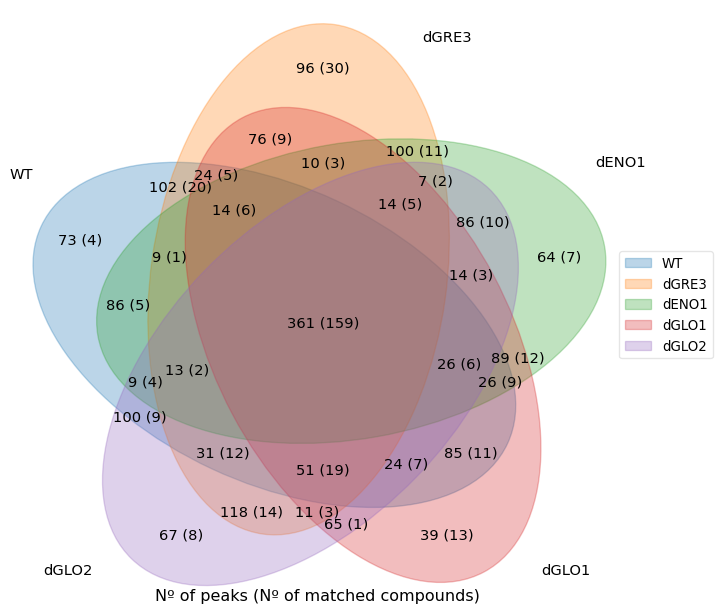

In [46]:
# Make a Venn diagram
labels = venn.get_labels([group_dfs[i].index for i in group_dfs], fill=['number'])
labels_ids = venn.get_labels([group_dfs_ids[i].index for i in group_dfs_ids], fill=['number'])

labels_all = {}
for i, j in labels.items():
    labels_all[i] = j + f' ({labels_ids[i]})'
    
c = [(c[0], c[1], c[2], 0.3) for c in colours]

if len(classes) == 2:
    fig, ax = venn.venn2(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 2 Classes
    plt.text(0.5,0, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 3:
    fig, ax = venn.venn3(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 3 Classes
    plt.text(0.5,-0.05, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 4:
    fig, ax = venn.venn4(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 4 Classes
    plt.text(0.5,0.05, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 5:
    fig, ax = venn.venn5(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 5 Classes
    plt.text(0.5,0, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center')
elif len(classes) == 6:
    fig, ax = venn.venn6(labels_all, names=classes, figsize=(8,8), fontsize=11, colors=c, constrained_layout=True) # 6 Classes
    plt.text(0.5,0.2, 'Nº of peaks (Nº of matched compounds)', fontsize=12, horizontalalignment='center') 
else:
    print(f'Venn Diagram can currently only be made with 2 to 6 different classes. You currently have {len(classes)} classes.')

# Save the Venn Diagram
#if len(classes) < 7:
#    fig.savefig('VennDiagram_plot.png', dpi=400)

**UpSetPlot** (not recommended for more than 6 classes also)

UpSetPlots made using the package UpSetPlot (https://pypi.org/project/UpSetPlot/0.8.0/)

See parameters two cells down

In [47]:
# Make an upsetplot
groups_dict = {}
for df in group_dfs:
    groups_dict[df] = group_dfs[df].index
ups = from_contents(groups_dict)

In [48]:
# Parameters
counts = True # Show absolute counts of metabolites on top of bars
percentages = False # Show percentage of metabolites on top of bars
include_annotated = False # Include annotated compounds as a bar of a different colour
annotated_colour = 'Red' # Choose the color for the bar
annotated_counts = False # Show absolute counts of annotated metabolites on top of the annotated metabolites bars

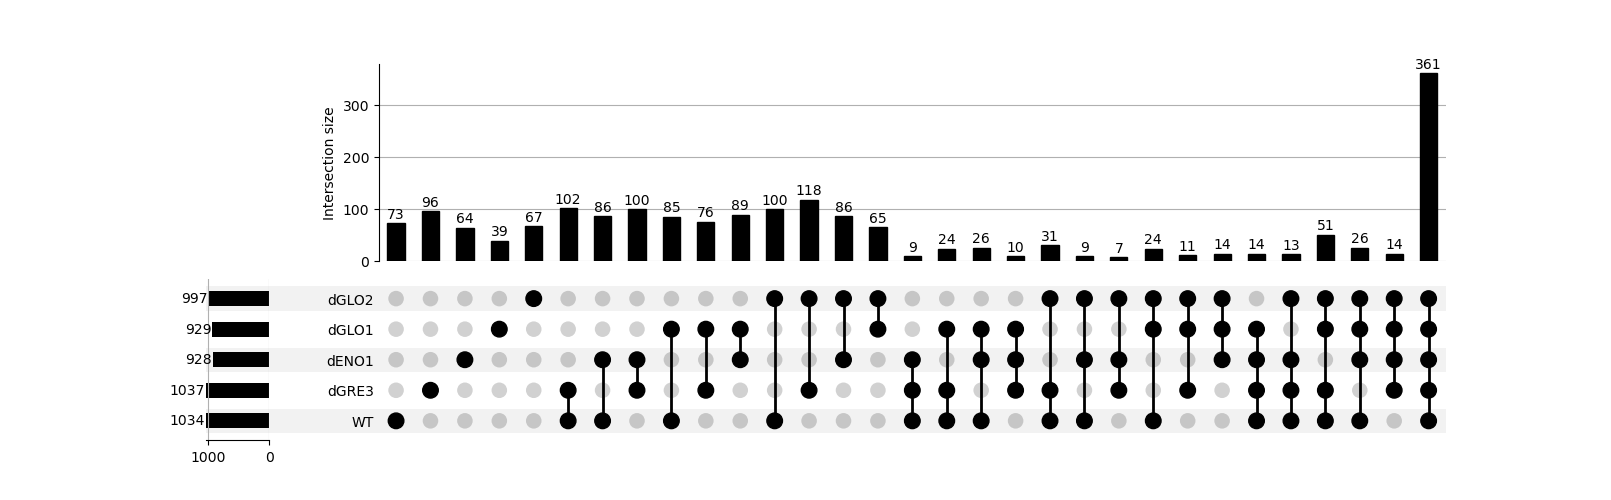

In [49]:
# Plotting UpSetPlot
f,ax = plt.subplots(1,1, constrained_layout=True)
ax.axis('Off')

# Plot Main Upset Plot
ax_dict = upsetplot.plot(ups, f, subset_size='count', show_counts=counts, show_percentages=percentages,
                         sort_categories_by='input', include_empty_subsets=include_annotated)

# Put counts of only annotated features if include_annotated = True
if include_annotated:
    groups_dict_id = {}
    for df in group_dfs_ids:
        groups_dict_id[df] = group_dfs_ids[df].index
    ups_id = from_contents(groups_dict_id)
    UpSet(ups_id, subset_size='count',facecolor=annotated_colour, sort_categories_by='input',
          include_empty_subsets=include_annotated).plot_intersections(ax_dict['intersections'])
    a=0
    # Put the counts over the red, you might have to adjust the +15 part to something else depending on the counts you have
    if annotated_counts:
        for i in upsetplot.query(ups_id,sort_categories_by='input', include_empty_subsets=True).subset_sizes:
            #print()
            ax_dict['intersections'].text(
                a,i+15, i, color='red', fontsize=10, zorder=15, horizontalalignment='center', weight="bold")
            a +=1

# Save the UpSet Plot
#fig.savefig('UpSetPlot_plot.png', dpi=400)

#### Setting an Excel file with the common and exclusive (to each class) annotated compounds

Change **GENERATE_Excel_file** to True if you want to generate the file.

In [50]:
# Setting the excel files for exclusive compounds
exclusive_dfs = {}
for i in exc_id.keys():
    df_temp = pd.DataFrame(index=exc_id[i].index)
    df_temp['Appear in Class Samples'] = exc_id[i].loc[:, sample_cols].notnull().sum(axis=1)
    df_temp['% of Class Samples'] = (exc_id[i].loc[:, sample_cols].notnull().sum(axis=1)) / target.count(i) * 100
    
    if 'Name' in exc_id[i].columns:
        df_temp['MetaboScape Match'] = exc_id[i]['Name']
    if 'Formula' in exc_id[i].columns:
        df_temp['MetaboScape Formula'] = exc_id[i]['Formula']
    for col in meta_cols:
        if col not in ['Neutral Mass', 'm/z', 'Name', 'Formula', 'Has Match?']:
            df_temp[col] = exc_id[i][col]
    df_temp.index = exc_id[i]['Neutral Mass']
    exclusive_dfs[i] = df_temp

In [51]:
# Example of Exclusive df, ordered by the number of samples of that class they appear in
print('Example for:', classes[0])
exclusive_dfs[classes[0]].sort_values(by='Appear in Class Samples', ascending=False)

Example for: WT


,Appear in Class Samples,% of Class Samples,MetaboScape Match,MetaboScape Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Neutral Mass,,,,,,,,,,,,,,,,
344.070798,3,100.000000,Thiamine monophosphate,C12H17N4O4PS,NaN,NaN,NaN,NaN,"[Q27094344, Q60998707]","[Thiamine phosphoric acid ester, Thiamine mono...","[C12H17N4O4PS, C12H17N4O4PS]",2,[DBK003083],[Thiamine(1+) monophosphate],[C12H17N4O4PS],1
400.209703,2,66.666667,Cincassiol B,C20H32O8,[HMDB0036855],[Cincassiol B],[C20H32O8],1,"[Q105175971, Q105273242, Q105353284, Q76423904...","[CID 162872780, Dictamnoside L, [(2R,3S,4S,5R,...","[C20H32O8, C20H32O8, C20H32O8, C20H32O8, C20H3...",13,NaN,NaN,NaN,NaN
414.219846,2,66.666667,NaN,C21H38N2S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[DBK0010095],[2-Ethylhexyl 4-phenylbenzophenone-2'-carboxyl...,[C28H30O3],1
246.121611,2,66.666667,L-beta-aspartyl-L-leucine,C10H18N2O5,"[HMDB0011166, HMDB0011172, HMDB0028756, HMDB00...","[L-beta-aspartyl-L-leucine, gamma-Glutamylvali...","[C10H18N2O5, C10H18N2O5, C10H18N2O5, C10H18N2O...",8,"[Q27137212, Q27145070, Q27137034]","[gamma-Glutamylvaline, Val-Glu, (S)-2-((S)-2-A...","[C10H18N2O5, C10H18N2O5, C10H18N2O5]",3,NaN,NaN,NaN,NaN


In [52]:
# Setting the excel files for common compounds
common_temp = pd.DataFrame(index=common_all_id.index)
common_temp['Appear in Samples'] = common_all_id.loc[:, sample_cols].notnull().sum(axis=1)
common_temp['% of Samples'] = (common_all_id.loc[:, sample_cols].notnull().sum(axis=1)) / len(target) * 100
if 'Name' in common_all_id.columns:
    common_temp['MetaboScape Match'] = common_all_id['Name']
if 'Formula' in common_all_id.columns:
    common_temp['MetaboScape Formula'] = common_all_id['Formula']
for col in meta_cols:
    if col not in ['Neutral Mass', 'm/z', 'Name', 'Formula', 'Has Match?']:
        common_temp[col] = common_all_id[col]
common_temp.index = common_all_id['Neutral Mass']
common_temp

,Appear in Samples,% of Samples,MetaboScape Match,MetaboScape Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count
Neutral Mass,,,,,,,,,,,,,,,,
307.083818,15,100.000000,Glutathione,C10H17N3O6S,"[HMDB0000125, HMDB0062697]","[Glutathione, Glutathionate(1-)]","[C10H17N3O6S, C10H17N3O6S]",2,NaN,NaN,NaN,NaN,[DBK0040],[Glutathione],[C10H17N3O6S],1
493.316816,15,100.000000,PC_16:1_9Z_0:0_,C24H48NO7P,"[HMDB0010383, HMDB0243799, HMDB0245288, HMDB02...","[LysoPC(16:1(9Z)/0:0), 1-(9Z-Nonadecenoyl)-gly...","[C24H48NO7P, C24H48NO7P, C24H48NO7P, C24H48NO7P]",4,"[Q27144179, Q106009879]",[1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholi...,"[C24H48NO7P, C24H48NO7P]",2,NaN,NaN,NaN,NaN
257.102875,15,100.000000,Glycerophosphocholine,C8H20NO6P,"[HMDB0000086, HMDB0252858]","[Glycerophosphocholine, Glycerylphosphorylchol...","[C8H20NO6P, C8H20NO6P]",2,"[Q28529699, Q60476027]","[Choline Alfoscerate, L-alpha-Glycerylphosphor...","[C8H20NO6P, C8H20NO6P]",2,[DBK004242],[Choline alfoscerate],[C8H20NO6P],1
347.063081,15,100.000000,Adenosine monophosphate,C10H14N5O7P,"[HMDB0000045, HMDB0001044, HMDB0003540, HMDB00...","[Adenosine monophosphate, b""2-Deoxyguanosine 5...","[C10H14N5O7P, C10H14N5O7P, C10H14N5O7P, C10H14...",9,"[Q318369, Q27456920, Q1936221, Q27103969, Q105...","[Adenosine monophosphate, 9-(5-O-phosphono-bet...","[C10H14N5O7P, C10H14N5O7P, C10H14N5O7P, C10H14...",8,"[DBK0028, DBK002477, DBK003128, DBK003312, DBK...","[Adenosine phosphate, 7-alpha-D-Ribofuranosyl-...","[C10H14N5O7P, C10H14N5O7P, C10H14N5O7P, C10H14...",6
254.224610,15,100.000000,Hypogeic acid,C16H30O2,"[HMDB0002186, HMDB0003229, HMDB0010735, HMDB00...","[Hypogeic acid, Palmitoleic acid, Trans-Hexa-d...","[C16H30O2, C16H30O2, C16H30O2, C16H30O2, C16H3...",17,"[Q27139858, Q412366, Q82105416, Q27888066, Q10...","[9-Hexadecenoic acid, (9Z)-, Palmitoleic acid,...","[C16H30O2, C16H30O2, C16H30O2, C16H30O2, C16H3...",48,[DBK003869],[Palmitoleic Acid],[C16H30O2],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284.235168,11,73.333333,Avocadyne,C17H32O3,"[HMDB0035473, HMDB0038685, HMDB0245318, HMDB02...","[Avocadyne, Muricatacin, 2-Tetradecylglycidate...","[C17H32O3, C17H32O3, C17H32O3, C17H32O3, C17H3...",5,"[Q27115972, Q27115973, Q105123372, Q105123370,...","[2-Methoxy-5Z-hexadecenoic acid, 2-Methoxy-6Z-...","[C17H32O3, C17H32O3, C17H32O3, C17H32O3, C17H3...",17,NaN,NaN,NaN,NaN
253.153885,11,73.333333,NaN,C11H19N5O2,NaN,NaN,NaN,NaN,"[Q27457463, Q77565427]","[Cyclo-(L-arginine-L-proline) inhibitor, Amino...","[C11H19N5O2, C11H19N5O2]",2,[DBK004028],[Verpacamide A],[C11H19N5O2],1
397.246411,9,60.000000,NaN,C21H35NO6,"[HMDB0241391, HMDB0241392, HMDB0241393]","[Tetradeca-9,11-dienedioylcarnitine, (6E,9E)-T...","[C21H35NO6, C21H35NO6, C21H35NO6]",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
GENERATE_Excel_file = False # Change to True if you want to generate the file
if GENERATE_Excel_file:
    writer = pd.ExcelWriter('Common_Exclusive_Compounds.xlsx', engine='xlsxwriter')

    common_temp.to_excel(writer, sheet_name='Common')

    text_format = writer.book.add_format({'text_wrap' : True, 'valign': 'top'})
    for i in range(1, len(common_temp.columns)+1):
        width=18
        if i in [1,2]:
            width=8
        elif common_temp.columns[i-1].endswith('IDs'):
            width=15
        elif common_temp.columns[i-1].endswith('count'):
            width=8
        elif common_temp.columns[i-1].endswith('names') or common_temp.columns[i-1].endswith('Name'):
            width=40
        writer.sheets['Common'].set_column(i,i,width,text_format)

    header_format = writer.book.add_format({'bold': True, 'text_wrap': True, 'valign': 'top'})
    # Overwrite both the value and the format of each header cell
    for col_num, value in enumerate(common_temp.columns.values):
        writer.sheets['Common'].write(0, col_num + 1, value, header_format)

    for a in exclusive_dfs.keys():
        exclusive_dfs[a].to_excel(writer, sheet_name=a+' Exclusive')

        text_format = writer.book.add_format({'text_wrap' : True, 'valign': 'top'})
        for i in range(1, len(exclusive_dfs[a].columns)+1):
            width=18
            if i in [1,2]:
                width=8
            elif common_temp.columns[i-1].endswith('IDs'):
                width=15
            elif common_temp.columns[i-1].endswith('count'):
                width=8
            elif common_temp.columns[i-1].endswith('names') or common_temp.columns[i-1].endswith('Name'):
                width=40
            writer.sheets[a+' Exclusive'].set_column(i,i,width,text_format)

        header_format = writer.book.add_format({'bold': True, 'text_wrap': True, 'valign': 'top'})
        # Overwrite both the value and the format of each header cell
        for col_num, value in enumerate(exclusive_dfs[a].columns.values):
            writer.sheets[a+' Exclusive'].write(0, col_num + 1, value, header_format)

    writer.save()

# Step 4: Unsupervised Statistical Analysis <a class="anchor" id="step-4"></a>

**Back to [Table of Contents](#toc)**

Unsupervised analysis means that the algorithms here do not receive the information of the different class labels.

Here, we show PCA and Hierarchical Clustering (HCA) Analysis.

The following functions were taken from the code git-hub repository 'binsim_paper' (from the files 'paper_binsim_data_prep.ipynb' and 'paper_binsim_unsupervised.ipynb').

In [54]:
def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

### Principal Component Analysis (PCA)

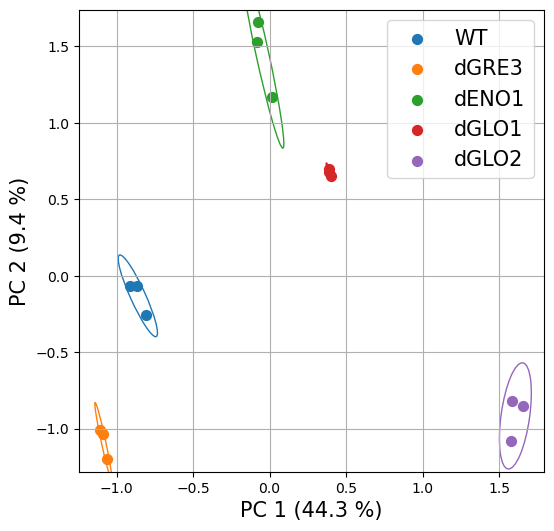

In [55]:
f, ax = plt.subplots(1, 1, figsize=(6,6)) # Change the size of the figure

principaldf, var = compute_df_with_PCs(treated_data, 
                                       n_components=2, # Select number of components to calculate
                                       whiten=True, labels=target, return_var_ratios=True)

# Plot PCA
ax.axis('equal')
lcolors = label_colours

plot_PCA(principaldf, lcolors, 
         components=(1,2), # Select components to see
         title='', # Select title of plot
         ax=ax)

# Remove ellipses by putting a # before the next line
plot_ellipses_PCA(principaldf, 
                  lcolors, 
                  components=(1,2), # Select components to see
                  ax=ax, 
                  q=0.95) # Confidence ellipse with 95% (q) confidence

ax.set_xlabel(f'PC 1 ({var[0] * 100:.1f} %)', size=15) # Set the size of labels
ax.set_ylabel(f'PC 2 ({var[1] * 100:.1f} %)', size=15) # Set the size of labels

plt.legend(fontsize=15) # Set the size of labels
plt.grid() # If you want a grid or not
plt.show()
#f.savefig('Name_PCAplot.png', dpi=400) # Save the figure

### Hierarchical Clustering Analysis (HCA)

Performing Hierarchical Clustering.

Distance metrics: 'euclidean' is the default, others are in https://docs.scipy.org/doc/scipy/reference/spatial.distance.html.

Linkage metrics: **'ward', 'average'**, 'centroid', 'single', 'complete', 'weighted', 'median'.

In [56]:
metric = 'euclidean' # Select distance metric
method = 'ward' # Select linkage method

distances = dist.pdist(treated_data, metric=metric)
Z = hier.linkage(distances, method=method)

hca_res = {'Z': Z, 'distances': distances}

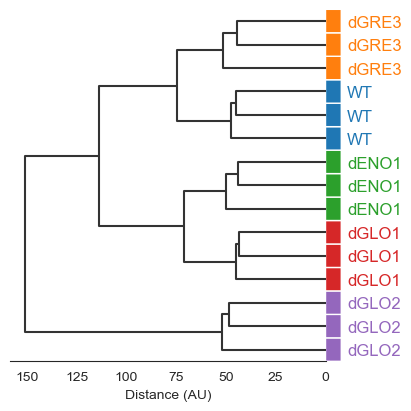

In [57]:
# Plot HCA
with sns.axes_style("white"):
    f, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True) # Set Figure Size
    plot_dendogram2(hca_res['Z'], 
                   target, ax=ax,
                   label_colors=label_colours,
                   title='', # Select title
                   color_threshold=0) # Select a distance threshold from where different sets of lines are coloured

    plt.show()
    #f.savefig('Name_HCAplot.png', dpi=400) # Save the figure

If you want a version of a dendrogram more easy to change parameters:

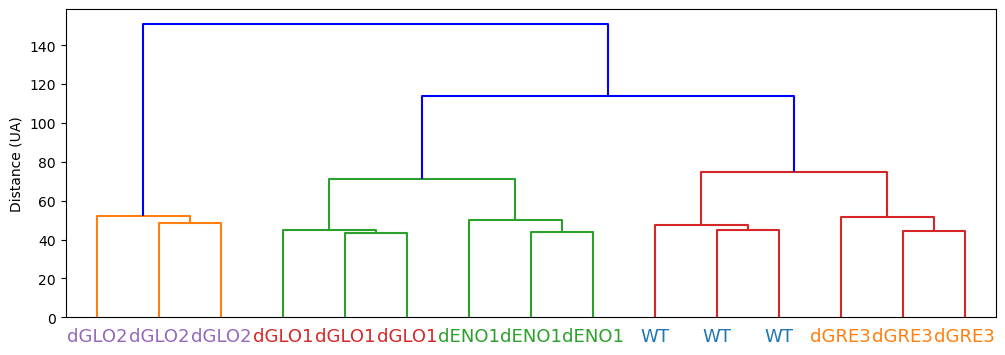

In [58]:
fig = plt.figure(figsize=(12,4))
# Plotting the dendrogram, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# For details on how you can change different aspects of the dendrograms
dn = hier.dendrogram(hca_res['Z'], labels=target,
                     leaf_font_size=13,
                     above_threshold_color='b')
# Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
# Coloring the labels with their specific colours
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colours[lbl.get_text()])

# Step 5: Supervised Statistical Analysis <a class="anchor" id="step-5"></a>

**Back to [Table of Contents](#toc)**

Supervised analysis means that the algorithms receive the information of the different class labels.

Here we show Random Forest and PLS-DA classifiers.

**Functions for this step are in metanalysis_standard.py and are an adaptation of functions in multianalysis.py (from the BinSim paper).**

## Step 5.1: Random Forest <a class="anchor" id="step-5.1"></a>

**Back to [Table of Contents](#toc)**

First: Minor optimization of the number of trees (200 is a good number to use though) - see when the accuracy of the model stops increasing and starts fluctuating around a certain value (that should be the minimum number of trees to use).

In [59]:
# Select a random seed (number between the ()) if you want to have constant results.
np.random.seed()

# See maximum number of trees to search
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
# Models will be built from 10 to 300 trees in 5 tree intervals
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=200)
clf = GridSearchCV(rf, values, cv=3) # Change cv to change cross-validation

print('Fitting RFs...', end=' ')

RF_optim = {'Treated':{}, 'BinSim':{}}
clf.fit(treated_data, target) # Fitting the data to RF models with all the different number of trees

# Storing results
RF_optim['Treated']['scores'] = list(clf.cv_results_['mean_test_score'])
RF_optim['Treated']['n_trees'] = list(clf.cv_results_['param_n_estimators'])

# BinSim turn
clf.fit(bin_data, target) # Fitting the data to RF models with all the different number of trees

# Storing results
RF_optim['BinSim']['scores'] = list(clf.cv_results_['mean_test_score'])
RF_optim['BinSim']['n_trees'] = list(clf.cv_results_['param_n_estimators'])


print('Done!')

Fitting RFs... Done!


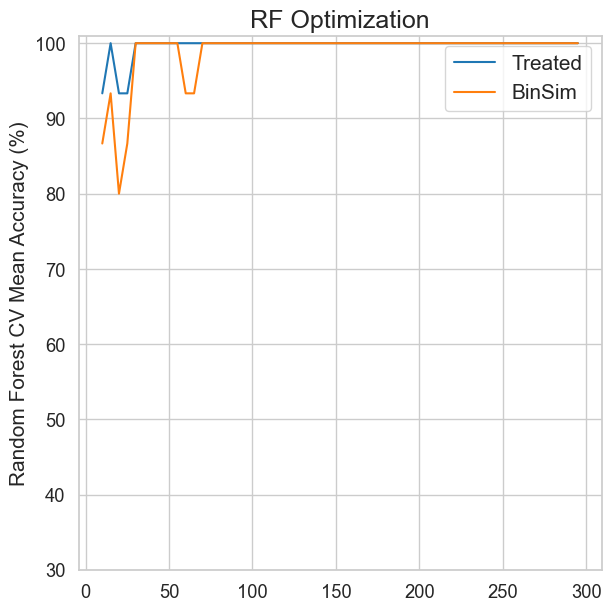

In [60]:
# Plotting the results and adjusting parameters of the plot
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(6,6), constrained_layout=True) # Set Figure Size

        c_map = sns.color_palette('tab10', 10)

        for treatment, c in zip(RF_optim.keys(), c_map):
            ax.plot(RF_optim[treatment]['n_trees'], [s*100 for s in RF_optim[treatment]['scores']], label=treatment, color=c)
        
        ax.set_ylabel('Random Forest CV Mean Accuracy (%)', fontsize=15) # Set the y_label and size
        ax.set_title('RF Optimization', fontsize=18) # Set the title and size
        ax.set_ylim([30,101]) # Set the limits on the y axis

        #f.suptitle('Optimization of the number of trees')
        ax.legend(fontsize=15) # Set the legend and size
        plt.show()

### Fitting the RF model

**See details of `RF_model` function (model fitting AND evaluation) in metanalysis_standard.py. Credit to initial function to the BinSim paper.** If this function breaks, say something.

In [61]:
# Choose a number for the seed for consistent results
np.random.seed()

n_trees=200 # Number of trees in the model

RF_results = metsta.RF_model(treated_data, target, # data and labels 
                return_cv=True, iter_num=5, # if you want cross calidation results and number of iterations for it
                n_trees=n_trees, # Number of trees in the model
                cv=None, n_fold=3, # choose a method of cross-validation (None is stratified cv) and the number of folds
         metrics = ('accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted')) # Choose the performance metrics

Performance analysis

In [62]:
results_summary = pd.DataFrame(columns=['Value', 'Standard Deviation'])
for k,v in RF_results.items():
    if k != 'model' and k != 'imp_feat':
        results_summary.loc[k] = np.mean(v), np.std(v)

print(results_summary)

                    Value  Standard Deviation
accuracy              1.0                 0.0
f1_weighted           1.0                 0.0
precision_weighted    1.0                 0.0
recall_weighted       1.0                 0.0


**Important Feature analysis**

See the most important features for class discrimination (sorted by importance).

In [63]:
imp_feats_rf = meta_data.copy()
imp_feats_rf.insert(0,'Bucket label', imp_feats_rf.index)
imp_feats_rf.insert(1,'Gini Importance', '')
for n in range(len(RF_results['imp_feat'])):
    imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]
imp_feats_rf = imp_feats_rf.sort_values(by='Gini Importance', ascending=False)
imp_feats_rf.index = range(1, len(imp_feats_rf)+1)

C:\Users\franc\AppData\Local\Temp\ipykernel_17500\2204001288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_rf['Gini Importance'].iloc[RF_results['imp_feat'][n][0]] = RF_results['imp_feat'][n][1]


In [64]:
imp_feats_rf.head(20) # Select number of features to see

,Bucket label,Gini Importance,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
1,477.3143781092 Da,0.001934,477.314378,478.321650,NaN,C33H39N3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,435.0624120409 Da,0.001777,435.062412,436.069690,NaN,C19H17NO9S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,218.0103817330 Da,0.001722,218.010382,219.017660,NaN,C5H14O3S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[DBK009267],[Calcium lactate],[C6H10CaO6],1,True
4,212.09091784835698 Da,0.001706,212.090918,213.098196,Glycyl-Histidine,C8H12N4O3,"[HMDB0028843, HMDB0028885, HMDB0257342]","[Glycyl-Histidine, Histidylglycine, 1H-Imidazo...","[C8H12N4O3, C8H12N4O3, C8H12N4O3]",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
5,288.0845029300 Da,0.001677,288.084503,289.091780,Phlorin,C12H16O8,"[HMDB0035589, HMDB0038341]","[Phlorin, Glucosylisomaltol]","[C12H16O8, C12H16O8]",2,"[Q105244462, Q104667210, Q104402222, Q10466787...","[2-Acetyl-3-furyl beta-L-glucopyranoside, (2S,...","[C12H16O8, C12H16O8, C12H16O8, C12H16O8, C12H1...",8,NaN,NaN,NaN,NaN,True
6,254.2237977120 Da,0.001624,254.223798,255.231070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,479.3011671946 Da,0.001537,479.301167,480.308440,PE_18:1_9Z_0:0_,C23H46NO7P,"[HMDB0011475, HMDB0011476, HMDB0011505, HMDB00...","[LysoPE(0:0/18:1(11Z)), LysoPE(0:0/18:1(9Z)), ...","[C23H46NO7P, C23H46NO7P, C23H46NO7P, C23H46NO7P]",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8,359.1427808692 Da,0.001535,359.142781,360.150060,NaN,C12H25NO11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,228.9199659849 Da,0.001486,228.919966,229.927240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
10,449.0356354461 Da,0.001486,449.035635,450.042910,NaN,C18H7N7O8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [65]:
# Saving Important feature dataset in an excel
SAVE_IMP_FEAT = False

# Saving the most important features by their fraction 'frac_feat_impor'.
# If None, saving the most important features based on a threshold 'VIP_Score_threshold'.
# If also None, save the full dataset of all features
frac_feat_impor = 0.02 # Fraction of features to save, If None the variable in the next line is used.
score_threshold = None # Only used if variable above is None, threshold of score to consider a feature important.

if SAVE_IMP_FEAT:
    if frac_feat_impor:
        max_idx = int(frac_feat_impor*len(imp_feats_rf))
        filt_imp_feats_rf = imp_feats_rf.iloc[:max_idx]
        filt_imp_feats_rf.to_excel(f'RF_ImpFeat_{frac_feat_impor*100}%.xlsx')
    elif score_threshold:
        filt_imp_feats_rf = imp_feats_rf[imp_feats_rf['Gini Importance'] > score_threshold]
        filt_imp_feats_rf.to_excel(f'RF_ImpFeat_GiniImpgreater{score_threshold}.xlsx')
    else:
        imp_feats_rf.to_excel(f'RF_FeatByImportance.xlsx')

### ROC curves (Receiver Operating Characteristic)

This basically gives you an area under curve that the closer it is to 1, the better our model. We also iterate this n_iter times so we have a softer curve and to give as a better indication of the actual area under curve (AUC). This plots the true positive rate against the false positive rate.

**Only possible for when your datasets have 2 classes. Choose the class which is considered the 'positive' class.**

Credit to initial function to the BinSim paper.

If you do not have 2 classes, skip ahead this section.

In [66]:
# Set a random seed for reproducibility
#np.random.seed()

#resROC = metsta.RF_ROC_cv(treated_data, target, # Data and target
#                            '1', # Positive label
#                            n_trees=200, # Number of trees of RF
#                            n_iter=15, # Number of iterations to repeat 
#                            cv=None, n_fold=3) # method of cross-validation (None is stratified cv) and the number of folds


In [67]:
# Plot the ROC curves 
#with sns.axes_style("whitegrid"):
#    with sns.plotting_context("notebook", font_scale=1.2):
#        f, ax = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True)
#        res = resROC
#        mean_fpr = res['average fpr']
#        mean_tpr = res['average tpr']
#        mean_auc = res['mean AUC']
#        mean_fpr = [0,] + list(mean_fpr)
#        mean_tpr = [0,] + list(mean_tpr)
#        ax.plot(mean_fpr, mean_tpr,
#               label=f'AUC = {mean_auc:.3f}',
#               lw=2, alpha=0.8)
#        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
#        ax.legend()
#        ax.set_xlim(None,1)
#        ax.set_ylim(0,None)
#        ax.set(xlabel='False positive rate', ylabel='True positive rate')

    #f.savefig(Name_BinSim_ROCcurve.jpg', dpi=400) # Save the figure

## Step 5.2: PLS-DA (Partial Least Squares - Discriminant Analysis) <a class="anchor" id="step-5.2"></a>

**Back to [Table of Contents](#toc)**

First, an optimization of the number of components of PLS-DA and a **set of functions for PLS-DA - `optim_PLSDA_n_components` for example - to see in metanalysis_standard.**

The VIPs scores are calculated using the function `_calculate_vips` in multianalysis.py that comes from the link https://www.researchgate.net/post/How-can-I-compute-Variable-Importance-in-Projection-VIP-in-Partial-Least-Squares-PLS as provided by Keiron Teilo O'Shea in that link.

In [68]:
%%capture --no-stdout
# above is to supress PLS warnings

# Set the random seed
np.random.seed()

max_comp = 15 # Max. number of components to search (the higher the more time it takes)

# Store Results
PLS_optim = metsta.optim_PLSDA_n_components(treated_data, target, # Data and target
                                    encode2as1vector=True,
                                    max_comp=max_comp, # Max. number of components to search
                                    kf=None, n_fold=3, # Cross validation to use (none is stratified CV) and nº of folds
                                    scale=False) # Set scale to True only if you did not do scaling in pre-treatments

In the figure below, $R^{2}$ and $Q^{2}$ are shown. You want to choose the number of components **where $Q^{2}$ specifically** stops increasing, so, in this case, 4 components will be chosen. 

- $Q^{2}$ - PLS score by its mean squared error based on the test samples, thus it is ideal to test if the model will overfit. This will increase until a certain number of components that should be chosen. Then it usually stabilizes but from a certain point it might start to decrease which would mean the model is overfitting. For example, in this case, we choose 4 components based on this score, but you could choose 5 or 6 and it would not affect the model a lot.
- $R^{2}$ - PLS score by its mean squared error based on the training samples used to make the model (it will be higher than $Q^{2}$ but it should not be used to choose the number of components. This metric always increases with the more components used which means it will overfit the model eventually.

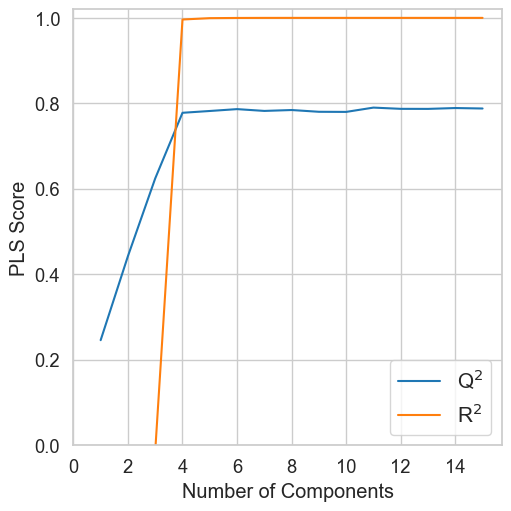

In [69]:
scores_cols = sns.color_palette('tab10', 10) # Set the colors for the lines
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True) # Set the figure size
        c = 0
        for i, values in PLS_optim.items():
            if i =='CVscores':
                name = 'Q$^2$'
            else:
                name = 'R$^2$'
            
            ax.plot(range(1, len(values) + 1), values, label=name, color = scores_cols[c])
            c = c+1
        
        ax.set(xlabel='Number of Components', # Set the label for the x axis
                ylabel='PLS Score') # Set the label for the Y axis
        ax.legend(loc='lower right', fontsize=15) # Set the legend
        ax.set_ylim([0, 1.02]) # Set limits for y axis
        ax.set_xticks(range(0, len(values), 2)) # Set ticks that appear in the bottom of x axis
        plt.show()

### PLS-DA model fitting

**See details of `PLSDA_model_cv` function (model fitting AND evaluation) in metanalysis_standard.py as adapted from the one in the BinSim paper.**

The VIPs scores are calculated using the function `_calculate_vips` in multianalysis.py that comes from the link https://www.researchgate.net/post/How-can-I-compute-Variable-Importance-in-Projection-VIP-in-Partial-Least-Squares-PLS as provided by Keiron Teilo O'Shea in that link.

The function `_generate_y_PLSDA` is also present in multianalysis.py.

In [70]:
%%capture --no-stdout
# above is to supress PLS warnings

n_comp = 4 # Number of components of PLS-DA model - very important

PLSDA_results = metsta.PLSDA_model_CV(treated_data, target, # Data and target
                       n_comp=n_comp, # Number of components of PLS-DA model - very important
                       kf = None, n_fold=3, # Cross validation to use (none is stratified CV) and nº of folds
                       iter_num=10, # Number of iterations of cross-validation to do
                       encode2as1vector=True,
                       scale=False, # Set scale to True only if you did not do scaling in pre-treatments
                       feat_type='VIP') # Feature Importance Metric to use, default is VIP scores (see function for others)

**Performance analysis**

In [71]:
results_summary = pd.DataFrame(columns=['Value', 'Standard Deviation'])
for k,v in PLSDA_results.items():
    if k != 'Q2' and k != 'imp_feat':
        results_summary.loc[k] = np.mean(v), np.std(v)

print(results_summary)

           Value  Standard Deviation
accuracy     1.0                 0.0
F1-scores    1.0                 0.0
precision    1.0                 0.0
recall       1.0                 0.0


**Important Feature analysis**

See the most important features for class discrimination.

In [72]:
imp_feats_plsda = meta_data.copy()
imp_feats_plsda.insert(0,'Bucket label', imp_feats_plsda.index)
imp_feats_plsda.insert(1,'VIP Score', '')
for n in range(len(PLSDA_results['imp_feat'])):
    imp_feats_plsda['VIP Score'][PLSDA_results['imp_feat'][n][0]] = PLSDA_results['imp_feat'][n][1]
imp_feats_plsda = imp_feats_plsda.sort_values(by='VIP Score', ascending=False)
imp_feats_plsda.index = range(1, len(imp_feats_plsda)+1)

C:\Users\franc\AppData\Local\Temp\ipykernel_17500\3239808401.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_plsda['VIP Score'][PLSDA_results['imp_feat'][n][0]] = PLSDA_results['imp_feat'][n][1]


In [73]:
imp_feats_plsda.head(20) # Select number of features to see

,Bucket label,VIP Score,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
1,385.3191962792 Da,2.176848,385.319196,424.28236,Pentadecanoylcarnitine,C22H43NO4,"[HMDB0062517, HMDB0240785, HMDB0240833, HMDB02...","[Pentadecanoylcarnitine, 13-Methyltetradecanoy...","[C22H43NO4, C22H43NO4, C22H43NO4, C22H43NO4, C...",14,[Q105114146],"[Acetic acid (2S,3R)-2-(acetylamino)-3-hydroxy...",[C22H43NO4],1,NaN,NaN,NaN,NaN,True
2,355.3450176173 Da,2.0959,355.345018,356.35229,NaN,C22H45NO2,[HMDB0248559],[Arachidoyl Ethanolamide],[C22H45NO2],1,[Q105029121],"[[(2R,3R)-2-aminotetradecan-3-yl] octanoate]",[C22H45NO2],1,NaN,NaN,NaN,NaN,True
3,770.6384724525 Da,2.092547,770.638472,771.64575,NaN,C37H94N4O5S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,307.0849666203 Da,2.051913,307.084967,308.09224,NaN,C11H21N3OS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,700.6716564106 Da,1.967135,700.671656,723.66096,NaN,C28H80N18O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,329.3293864202 Da,1.944017,329.329386,330.33666,NaN,C20H43NO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,477.3143781092 Da,1.893626,477.314378,478.32165,NaN,C33H39N3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,440.0931035423 Da,1.8845,440.093104,441.10038,NaN,C16H28N2O4S4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,257.2718866583 Da,1.858649,257.271887,258.27916,NaN,C16H35NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
10,518.1594907263 Da,1.84745,518.159491,519.16677,NaN,C15H18N16O6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [74]:
# Saving Important feature dataset in an excel
SAVE_IMP_FEAT = False

# Saving the most important features by their fraction 'frac_feat_impor'.
# If None, saving the most important features based on a threshold 'VIP_Score_threshold'.
# If also None, save the full dataset of all features
frac_feat_impor = 0.02 # Fraction of features to save, If None the variable in the next line is used.
VIP_Score_threshold = 1 # Only used if variable above is None, threshold of score to consider a feature important.

if SAVE_IMP_FEAT:
    if frac_feat_impor:
        max_idx = int(frac_feat_impor*len(imp_feats_plsda))
        filt_imp_feats_plsda = imp_feats_plsda.iloc[:max_idx]
        filt_imp_feats_plsda.to_excel(f'PLSDA_ImpFeat_{frac_feat_impor*100}%.xlsx')
    elif VIP_Score_threshold:
        filt_imp_feats_plsda = imp_feats_plsda[imp_feats_plsda['VIP Score'] > VIP_Score_threshold]
        filt_imp_feats_plsda.to_excel(f'PLSDA_ImpFeat_VIPgreater{VIP_Score_threshold}.xlsx')
    else:
        imp_feats_plsda.to_excel(f'PLSDA_FeatByImportance.xlsx')

### Sample Projection on the two most important Components/Latent Variables of PLS models 

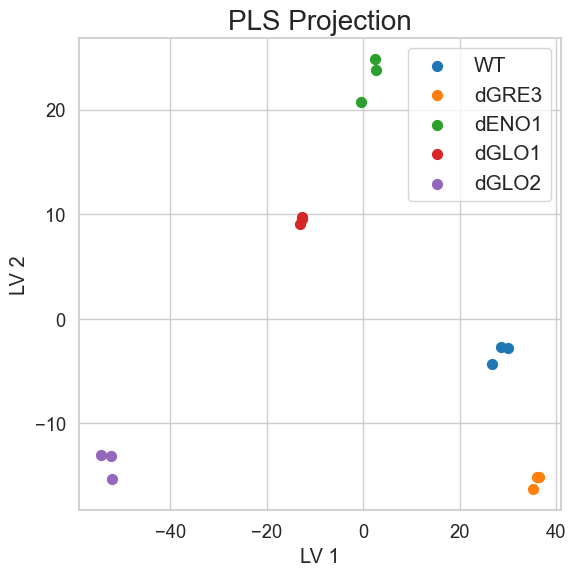

In [75]:
n_components = 4 # Nº of componentes

model, scores = fit_PLSDA_model(treated_data, target,
                                n_comp=n_components, scale=False, # Only true if scaling was not done earlier
                                encode2as1vector=True,
                                lv_prefix='LV ', label_name='Label')

lcolors = label_colours

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(6,6)) # Set up fig size
        plot_PCA(scores, lcolors, title="PLS Projection", ax=ax,
                components=(1,2)) # Select components to see
        plt.title('PLS Projection', fontsize=20) # Title
        plt.legend(loc='upper right', ncol=1, fontsize=15)  # Legend           
        plt.tight_layout()
        plt.show()
        
        #f.savefig('Name_PLSplot.jpg', dpi=400) # Save the figure

# Step 6: Univariate Analysis and Fold-Change Analysis <a class="anchor" id="step-6"></a>

**Back to [Table of Contents](#toc)**

In this section, both Univariate Analysis and Fold-Change analysis are performed outputting a DataFrame ordered by lowest _p_-value to highest and with the columns of Fold change and logarithmic Fold Change.

The Fold change is calculated in a dataset with missing values imputed and normalized after. **This means that with our very high number of missing values in FT-ICR-MS data, it affects the calculation of the fold change a lot. Thus, take this fold changes values with a grain (or multiple grains that are actually more like rocks than grains) of salt.**

Choose between the parametric **t-test** and non-parametric **Mann-Whitney test**.

**Warning**: This type of analysis is only done between 2 classes. If you have more than 2 classes, you can also choose one as the control class and an univariate analysis will be performed off all classes against the one specified and the output will be  dictionary where the keys will be each non-control class and the values the corresponding DataFrame. Furthermore, data pre-treatment will be re-applied to the section of the data considering those classes only each time, so **check if the pre-treatment is the same as you have done in step 3**.

All the functions come from the multianalysis.py file (from the BinSim paper) but most of them were slightly altered and put in the metanalysis_standard.py file to be able to specify a control and test class.

First, univariate analysis functions.

Choose **control** class

In [76]:
control_class = classes[0]
control_class

'WT'

Choose **_p_-value significancy** threshold. Usual values are: 0.05, 0.01, 0.001. If you **do not want** to filter the data based on a _p_-value threshold, make alpha=**None**.

In [77]:
alpha = None
alpha = 0.05 # If you use Mann-Whitney with low number of samples you might have to change this alpha
# It can be the correct appraoch with a lot of missing values though
# With Mann-Whitney test, there will be a set of discrete p-values as well

Choose **Fold change** threshold value.

If you want to only select from the significant features, those that have a fold change greater than X, change **abs_log2FC_threshold**. This value is in **log 2 of the absolute fold change**. For example, if you want to only consider features that have a fold change greater than 2-fold (2 or 0.5), then the abs_log2FC_threshold should be 1. If you want it to be greater than 3-fold, the threshold should be np.log2(3).

In [78]:
abs_log2FC_threshold = None # As a default, I will choose not to perform this step
# Example for 2-fold threshold: abs_log2FC_threshold = 1 or np.log2(2)
# Example for 3-fold threshold: abs_log2FC_threshold = np.log2(3)

Perform Univariate Analysis

If you have more than 2 classes, the pre-treatment must be equal to the pre-treatment made in step 2, thus we use the same variables as before (hence the importance of choosing the pre-treatment by the variables and not in the function itself in step 2.

In [79]:
if len(classes) == 2:
    test_class = [cl for cl in classes if cl != control_class][0]
    # Perform Univariate Analysis
    univariate_results = metsta.compute_FC_pvalues_2groups(normalized=univariate_data, # Used for Fold-Change Computation
                                  processed=treated_data, # Used for p-value computation
                                  labels=target, # Labels of the samples
                                  control_class=control_class, # Control class
                                  test_class=test_class, # Non-control class
                                  equal_var=True, # Consider variance between groups as equal
                                  useMW=True) # Use Mann-Whitney Test or standard T-test
    
    # Select only Features considered significative
    if alpha:
        filt_uni_results = univariate_results[univariate_results['FDR adjusted p-value'] < alpha].copy()
    else:
        filt_uni_results = univariate_results.copy()
    
    # Select features that have an absolute fold change (in log2) greater than abs_log2FC_threshold
    if abs_log2FC_threshold:
        # Calculate absolute Log2 Fold-Change
        filt_uni_results['abs_log2FC'] = abs(filt_uni_results['log2FC'])
        # Select
        filt_uni_results = filt_uni_results[filt_uni_results['abs_log2FC'] > abs_log2FC_threshold]
        filt_uni_results = filt_uni_results.drop(columns='abs_log2FC')
        
    print('Univariate Analysis Done.')

# More than 2 classes
else:
    test_classes = [cl for cl in classes if cl != control_class]
    univariate_results = {}
    filt_uni_results = {}
    univariate_df = {}

    for test_class in test_classes: # For each non-control class
        # Select only the samples of the control and current test class
        selection = [i in [control_class, test_class] for i in target]
        target_temp = list(np.array(target)[selection])
        
        file_temp = annotated_data[sample_cols].copy()
        file_temp = file_temp.loc[:, selection]
        t_data,_,filt_data,_,_ = metsta.filtering_pretreatment(
                          file_temp, list(np.array(target)[selection]), file_temp.columns,
           #### Everything here must be the same as in step 2
                          filt_method, filt_kw, extra_filt, mvi, mvi_kw, norm, norm_kw, tf, tf_kw, scaling, scaling_kw)
        #t_data = treated_data.drop(columns='555.2692975341 Da') # Remove ref_feat if normalization was NOT ref_feat
        univariate_df[test_class] = [t_data, target_temp]
        
        # Perform Univariate Analysis on this newly acquired data
        univariate_results[test_class] = metsta.compute_FC_pvalues_2groups(
                                  normalized=filt_data, # Used for Fold-Change Computation
                                  processed=t_data, # Used for p-value computation
                                  labels=target_temp, # Labels of the samples
                                  control_class=control_class, # Control class
                                  test_class=test_class, # Non-control class
                                  equal_var=True, # Consider variance between groups as equal
                                  useMW=False) # Use Mann-Whitney Test if True or standard T-test if False
        
        # Select only Features considered significative
        if alpha:
            filt_uni_results[test_class] = univariate_results[test_class][univariate_results[test_class][
                'FDR adjusted p-value'] < alpha].copy()
        else:
            filt_uni_results[test_class] = univariate_results[test_class].copy()
        
        # Select features that have an absolute fold change (in log2) greater than abs_log2FC_threshold
        if abs_log2FC_threshold:
            # Calculate absolute Log2 Fold-Change
            filt_uni_results[test_class]['abs_log2FC'] = abs(filt_uni_results[test_class]['log2FC'])
            # Select
            filt_uni_results[test_class] = filt_uni_results[test_class][
                filt_uni_results[test_class]['abs_log2FC'] > abs_log2FC_threshold]
            filt_uni_results[test_class] = filt_uni_results[test_class].drop(columns='abs_log2FC')

        print(f'Univariate Analysis {test_class} vs. {control_class} Done.')

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')


Univariate Analysis dGRE3 vs. WT Done.


C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')


Univariate Analysis dENO1 vs. WT Done.


C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')


Univariate Analysis dGLO1 vs. WT Done.


C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')


Univariate Analysis dGLO2 vs. WT Done.


In [80]:
# Add a column with the meta data of each feature
temp_meta_data = meta_data[[i for i in meta_data.columns if i not in ['Neutral Mass', 'm/z']]]

# If you have 2 classes
if len(classes) == 2:
    filt_uni_results = pd.concat((filt_uni_results, temp_meta_data.loc[filt_uni_results.index]), axis=1)

# More than 2 classes
else:
    for test_class in filt_uni_results.keys():
        filt_uni_results[test_class] = pd.concat((filt_uni_results[test_class], temp_meta_data.loc[
            filt_uni_results[test_class].index]), axis=1)

Get the results in an Excel if you want to

In [81]:
Univariate_Excel = False # Change to True to have the Excels
if Univariate_Excel:
    if len(classes) == 2:
        filt_uni_results.to_excel(f'UniAnalysis_pvalue{alpha}_log2FC{abs_log2FC_threshold}.xlsx')
    else:
        for i in filt_uni_results:
            filt_uni_results[i].to_excel(f'UniAnalysis_class{i}_pvalue{alpha}_log2FC{abs_log2FC_threshold}.xlsx')

**Example Results (for more than 2 classes, a random class was chosen)**

The first four columns have the results of the univariate analysis

In [82]:
if len(classes) == 2:
    example_results = filt_uni_results
    example_heatmap = treated_data
    example_target = target
else:
    example_results = filt_uni_results[test_classes[0]]
    example_heatmap = univariate_df[test_classes[0]][0]
    example_target = univariate_df[test_classes[0]][1]

In [83]:
example_results

,p-value,FDR adjusted p-value,FC (dGRE3 / WT),log2FC,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,
307.0849666203 Da,1.470320e-10,1.332110e-07,0.018243,-5.776492,NaN,C11H21N3OS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
276.1572942597 Da,6.155772e-10,2.788565e-07,11.500509,3.523626,NaN,C13H24O6,"[HMDB0250877, HMDB0257660]","[Daumone, 10-(2,3-Dihydroxypropoxy)-10-oxodeca...","[C13H24O6, C13H24O6]",2,"[Q27147958, Q110193673, Q115967659]","[Daumone, (2R,3R,4S,5S,6R)-2-hept-3-enoxy-6-(h...","[C13H24O6, C13H24O6, C13H24O6]",3,NaN,NaN,NaN,NaN,True
214.1205863993 Da,4.296770e-09,1.297624e-06,10.425464,3.382040,5-Hexyltetrahydro-2-oxo-3-furancarboxylic acid,C11H18O4,"[HMDB0030984, HMDB0030985, HMDB0030986]",[5-Hexyltetrahydro-2-oxo-3-furancarboxylic aci...,"[C11H18O4, C11H18O4, C11H18O4]",3,"[Q104397867, Q104202071, Q104400655, Q75056811...","[2-Hexylidene-3-methylsuccinic acid, 2-Hexylid...","[C11H18O4, C11H18O4, C11H18O4, C11H18O4, C11H1...",31,NaN,NaN,NaN,NaN,True
257.9722002828 Da,7.805009e-09,1.426631e-06,0.194215,-2.364273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
200.2930225885 Da,8.790292e-09,1.426631e-06,0.102448,-3.287031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220.3695593650 Da,1.115194e-02,4.299429e-02,1.410766,0.496479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
227.18851578326942 Da,1.152726e-02,4.425295e-02,0.848508,-0.237000,NaN,C13H25NO2,NaN,NaN,NaN,NaN,"[Q105007824, Q105007825]","[1-[(2S,6R)-6-[(2S)-2-hydroxypentyl]piperidin-...","[C13H25NO2, C13H25NO2]",2,NaN,NaN,NaN,NaN,True
303.1542594174 Da,1.176304e-02,4.496757e-02,1.352240,0.435351,Arginyl-Glutamic acid,C11H21N5O5,"[HMDB0028708, HMDB0028813, HMDB0029143, HMDB03...","[Arginylglutamic acid, Glutamylarginine, gamma...","[C11H21N5O5, C11H21N5O5, C11H21N5O5, C11H21N5O5]",4,[Q104913500],[Gamma-glutamyl-Arginine],[C11H21N5O5],1,[DBK0010993],[Arginine PCA],[C11H21N5O5],1,True


See results ordered by **_p_-value**

In [84]:
example_results.head(20)

,p-value,FDR adjusted p-value,FC (dGRE3 / WT),log2FC,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,
307.0849666203 Da,1.470320e-10,1.332110e-07,0.018243,-5.776492,NaN,C11H21N3OS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
276.1572942597 Da,6.155772e-10,2.788565e-07,11.500509,3.523626,NaN,C13H24O6,"[HMDB0250877, HMDB0257660]","[Daumone, 10-(2,3-Dihydroxypropoxy)-10-oxodeca...","[C13H24O6, C13H24O6]",2,"[Q27147958, Q110193673, Q115967659]","[Daumone, (2R,3R,4S,5S,6R)-2-hept-3-enoxy-6-(h...","[C13H24O6, C13H24O6, C13H24O6]",3,NaN,NaN,NaN,NaN,True
214.1205863993 Da,4.296770e-09,1.297624e-06,10.425464,3.382040,5-Hexyltetrahydro-2-oxo-3-furancarboxylic acid,C11H18O4,"[HMDB0030984, HMDB0030985, HMDB0030986]",[5-Hexyltetrahydro-2-oxo-3-furancarboxylic aci...,"[C11H18O4, C11H18O4, C11H18O4]",3,"[Q104397867, Q104202071, Q104400655, Q75056811...","[2-Hexylidene-3-methylsuccinic acid, 2-Hexylid...","[C11H18O4, C11H18O4, C11H18O4, C11H18O4, C11H1...",31,NaN,NaN,NaN,NaN,True
257.9722002828 Da,7.805009e-09,1.426631e-06,0.194215,-2.364273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
200.2930225885 Da,8.790292e-09,1.426631e-06,0.102448,-3.287031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
367.2125092496 Da,9.447884e-09,1.426631e-06,0.119969,-3.059271,NaN,C16H34NO6P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
246.0068736343422 Da,2.370292e-08,3.067835e-06,0.072549,-3.784908,NaN,C7H10N4S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
257.2718866583 Da,2.832922e-08,3.084516e-06,38.368860,5.261864,NaN,C16H35NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
290.0330718824 Da,3.064089e-08,3.084516e-06,0.175940,-2.506848,NaN,C9H14N4OS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


See biggest fold changes from the test class in relation to the control class (1st cell) and vice-versa (2nd cell)

In [85]:
example_results.sort_values(by='log2FC', ascending=False).head(20)

,p-value,FDR adjusted p-value,FC (dGRE3 / WT),log2FC,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,
257.2718866583 Da,2.832922e-08,3.084516e-06,38.368860,5.261864,NaN,C16H35NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
210.0868442668 Da,4.278884e-07,1.296291e-05,27.344670,4.773188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
361.2464368707 Da,3.342090e-03,1.491593e-02,26.485321,4.727121,NaN,C18H35NO6,NaN,NaN,NaN,NaN,"[Q82917269, Q105263134, Q82917268, Q105196560]","[Broussonetine F, (13S)-13-[(2R,3R,4R,5R)-3,4-...","[C18H35NO6, C18H35NO6, C18H35NO6, C18H35NO6]",4,NaN,NaN,NaN,NaN,True
188.1047773826 Da,6.212255e-08,3.763839e-06,21.270582,4.410788,Azelaic acid,C9H16O4,"[HMDB0000784, HMDB0011717, HMDB0032200, HMDB00...","[Azelaic acid, Nonate, cis- and trans-Ethyl 2,...","[C9H16O4, C9H16O4, C9H16O4, C9H16O4, C9H16O4, ...",10,"[Q27162058, Q83077965, Q27292041, Q105002555, ...","[2,4-Dimethylpimelic acid, Eucommiol, Ethyl 3-...","[C9H16O4, C9H16O4, C9H16O4, C9H16O4, C9H16O4, ...",19,[DBK00436],[Azelaic acid],[C9H16O4],1,True
194.1153114956 Da,3.499699e-08,3.170728e-06,21.125075,4.400885,Tetraethylene glycol,C8H18O5,[HMDB0094708],[Tetraethylene glycol],[C8H18O5],1,"[Q105196464, Q77494702]","[(2S,4S)-4-(hydroxymethyl)-5-methylhexane-1,2,...","[C8H18O5, C8H18O5]",2,NaN,NaN,NaN,NaN,True
343.2358883298 Da,1.030734e-07,5.188028e-06,20.648965,4.367998,NaN,C18H33NO5,"[HMDB0241165, HMDB0241166, HMDB0241167, HMDB02...","[2-Hydroxyundec-3-enoylcarnitine, 2-Hydroxyund...","[C18H33NO5, C18H33NO5, C18H33NO5, C18H33NO5, C...",10,"[Q105217849, Q105217850, Q105346023, Q10521357...","[Broussonetine V, Broussonetine O, Broussoneti...","[C18H33NO5, C18H33NO5, C18H33NO5, C18H33NO5, C...",11,NaN,NaN,NaN,NaN,True
410.3912416732 Da,8.018588e-07,2.065558e-05,19.550678,4.289147,Squalene,C30H50,"[HMDB0000256, HMDB0247780]","[Squalene, Squalen]","[C30H50, C30H50]",2,"[Q407560, Q72508801, Q105368604, Q105148346, Q...","[Squalene, (E,E,E,E)-Squalene, (6Z,10E,14Z,18E...","[C30H50, C30H50, C30H50, C30H50, C30H50, C30H5...",111,[DBK007841],[Squalene],[C30H50],1,True
389.2777116579 Da,4.105269e-08,3.381249e-06,14.180375,3.825824,NaN,NaN,NaN,NaN,NaN,NaN,[Q76386687],[Sphingofungin B],[C20H39NO6],1,NaN,NaN,NaN,NaN,True
317.2202471039 Da,2.594467e-06,4.457852e-05,13.426712,3.747034,3-hydroxynonanoyl carnitine,C16H31NO5,[HMDB0061635],[3-hydroxynonanoyl carnitine],[C16H31NO5],1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [86]:
example_results.sort_values(by='log2FC', ascending=False).tail(20)

,p-value,FDR adjusted p-value,FC (dGRE3 / WT),log2FC,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
Bucket label,,,,,,,,,,,,,,,,,,,
452.3613644963 Da,1.190777e-06,2.568677e-05,0.111939,-3.159219,NaN,C26H48N2O4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
325.0494758924 Da,1.816371e-06,3.358433e-05,0.111276,-3.167787,NaN,C12H7N9OS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
335.3188469649 Da,2.744534e-05,2.437792e-04,0.105222,-3.248488,Pipericine,C22H41NO,"[HMDB0031678, HMDB0302880]","[Pipericine, N-Isobutyloctadeca-trans-2-trans-...","[C22H41NO, C22H41NO]",2,"[Q82656358, Q105225737, Q76810073, Q105140062,...","[N-Isobutyloctadeca-2,4-dienamid, Pipericine, ...","[C22H41NO, C22H41NO, C22H41NO, C22H41NO, C22H4...",6,NaN,NaN,NaN,NaN,True
522.1746334422 Da,3.699428e-03,1.627030e-02,0.105016,-3.251323,NaN,C26H34O7S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
512.9878460930 Da,2.740198e-06,4.513854e-05,0.102817,-3.281846,NaN,C17H12N3O12PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
200.2930225885 Da,8.790292e-09,1.426631e-06,0.102448,-3.287031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
292.1715269729 Da,1.804826e-03,8.561112e-03,0.102015,-3.293144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
343.5336148888 Da,8.207514e-07,2.065558e-05,0.101036,-3.307055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
312.1613599022 Da,4.612450e-06,6.429046e-05,0.094093,-3.409774,NaN,C14H32OS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


**Heatmap** of the example shown considering only the significant features from the univariate analysis (can be better)

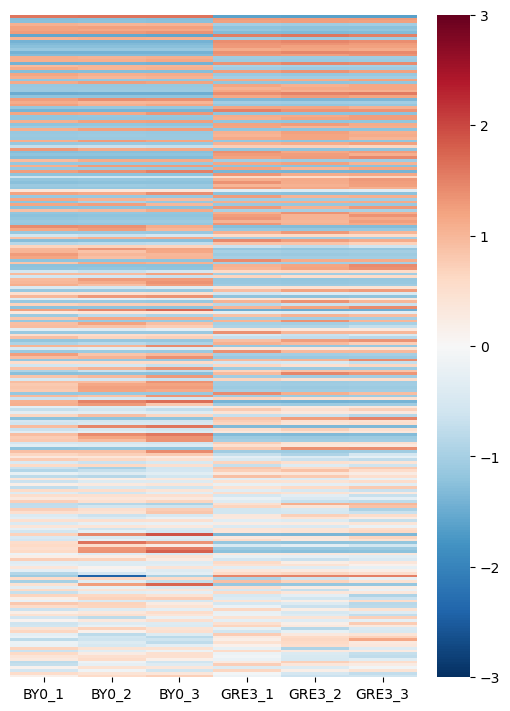

In [87]:
# Simple heatmap comparing intensities in treated_data
f, ax = plt.subplots(1,1, figsize=(5, 7), constrained_layout=True) # Set figure size
sns.heatmap(example_heatmap.T.loc[example_results.index],
            cmap='RdBu_r', # Select colormap to use
            vmin=-3, vmax=3) # Adjust minimum and maximum values in the Heatmap colorbar
ax.tick_params(left=False)
ax.set_yticklabels('')
ax.set_ylabel('')
plt.show()

# Step 7: Make Van Krevelen Diagrams, Kendrick Mass Defect Plots and Chemical Composition series for your samples <a class="anchor" id="step-7"></a>

**Back to [Table of Contents](#toc)**

In [88]:
SmartFormula = True # Is there a SmartFormula Annotation? Change to False if not

if SmartFormula:
    formula_subset = "Formula"
else:
    formula_subset = meta_cols_formulas
print(formula_subset)

Formula


**Van Krevelen Plots**

See the options for **color_dots_by** in the beginning of the next cell.

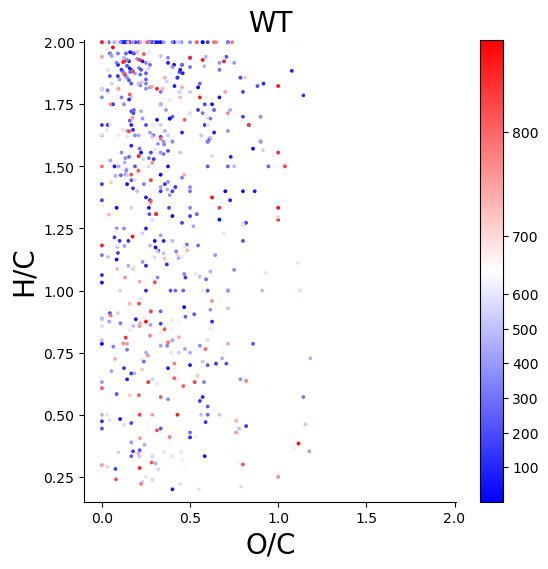

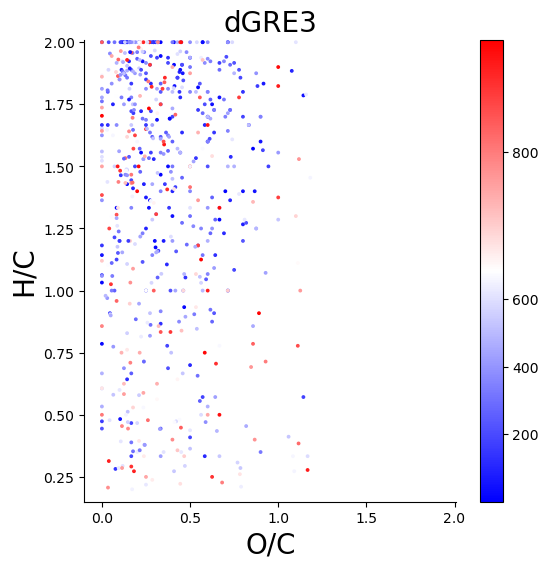

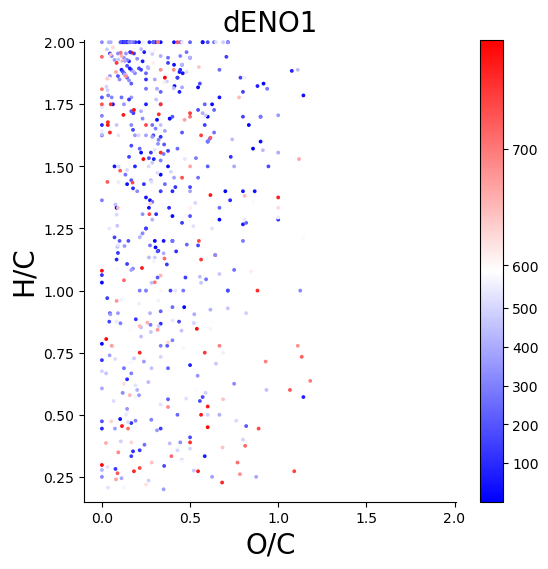

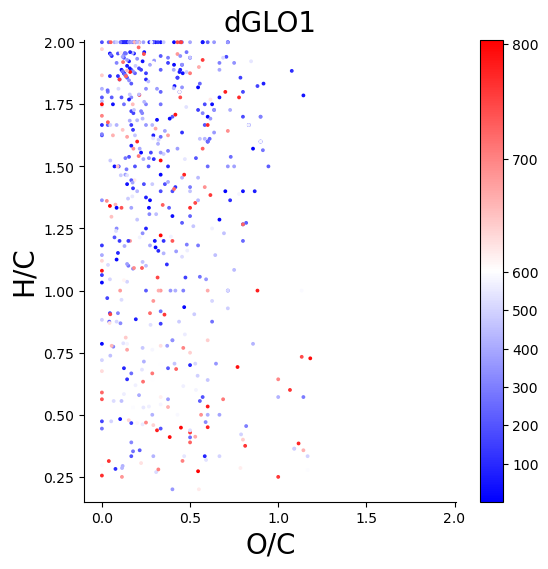

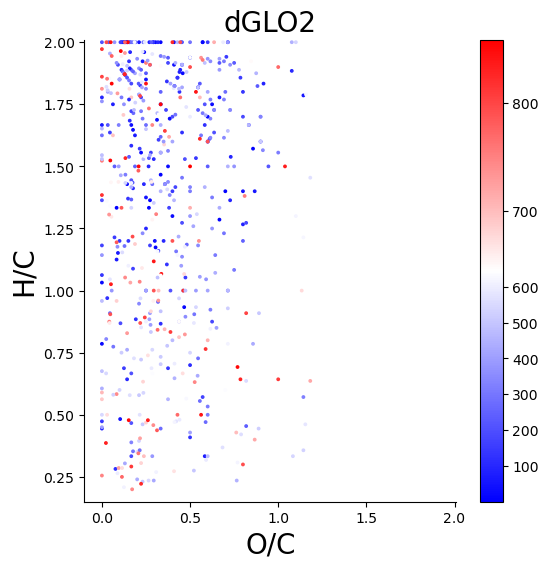

In [89]:
# Van Krevelen Diagrams
color_dots_by = 'Rank' # Other option 'logInt'
# Van Krevelen points (peaks) are coloured based on their average intensity
# Rank - colored by the rank of their average intensity compared to others
# logInt - colored by the logarithm of their averaged intensity compared to others

midpoint = 0.75 # Marks the point where the color passes from the low intensity color to the high intensity
# 0.75 means 75% of points will be coloured with the low intensity color (stronger the lesser the intensity)

for g in group_dfs:
    # Calculating H/C and O/C ratios
    forms = group_dfs[g].dropna(subset=formula_subset, how='all')
    elems = metsta.create_element_counts(forms, formula_subset=formula_subset)
    

    f, ax = plt.subplots(1,1, figsize=(6,6)) # Setting axes for the figs
    
    # Make the vector that will govern the colour of the plots
    if color_dots_by == 'Rank':
        c = univariate_data[elems.index].loc[np.array(target) == g].mean().rank(ascending=False)
        slope_midpoint = midpoint*len(univariate_data[elems.index].columns)
    elif color_dots_by == 'logInt':
        c = np.log(univariate_data[elems.index].loc[np.array(target) == g].mean())
        slope_midpoint = c.sort_values().iloc[int(midpoint*len(elems.index))]
    
    if formula_subset == 'Formula':
        y = elems['H/C'].loc[c.index]
        x = elems['O/C'].loc[c.index]
    else:
        y = elems['H/C']
        x = elems['O/C']
    
    plt.scatter(x, y, s=3, c=c, cmap='bwr', norm=TwoSlopeNorm(slope_midpoint))
    plt.xlabel('O/C', fontsize=20)
    plt.ylabel('H/C', fontsize=20)
    ax.margins(y=.1)
    ax.set_ylim([0.15,2.01])
    ax.set_xlim([-0.1,2.01])
    plt.colorbar()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(g, fontsize=20)
    
    
    #f, ax = plt.subplots(1,1, figsize=(8,8)) # Setting axes for the figs
    #VK_plot(elems, ax=ax)
    #plt.title(g, fontsize=20)
    
    #f.savefig('Name_VKplot_' + g + '.jpg', dpi=400) # Save the figure

**Kendrick Mass Defect Plots**

See the options for **rounding** in the beginning of the next cell.

Coloring does not work in Kendrick Mass Defect without using SmartFormula by choice since the Python script can technically annotate multiple formulas to each peak. This is a very very fringe case but it still removes that possible ambiguity.

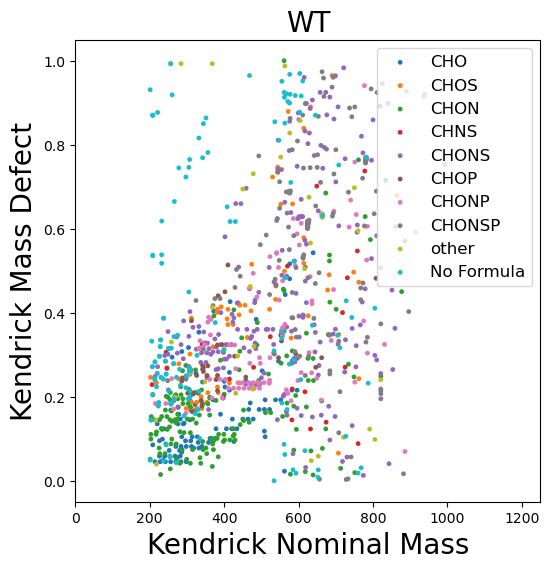

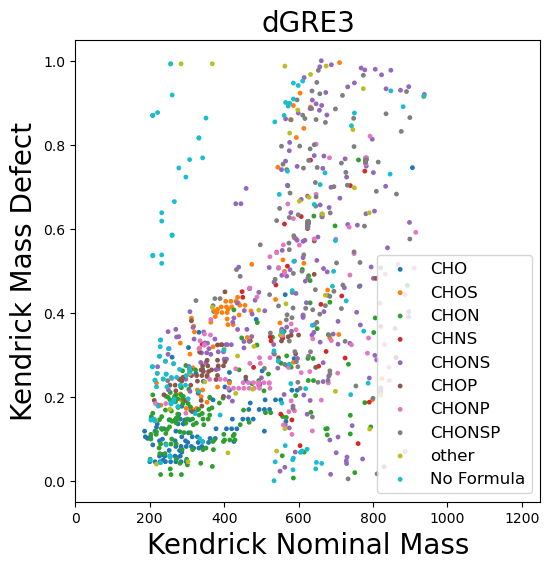

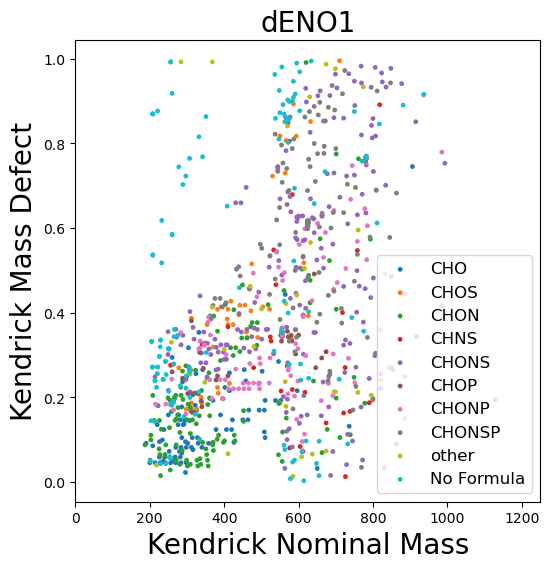

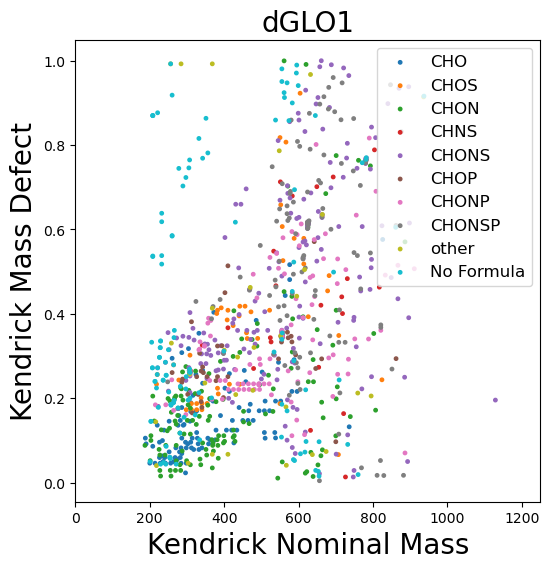

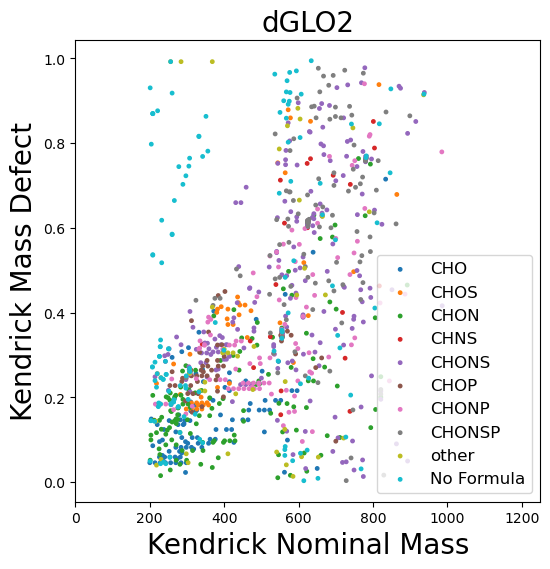

In [90]:
rounding = 'up' # 'up' or 'nearest' - how Kendrick Nominal Mass is obtained by rounding up or to the nearest integer

# Put these two lines instead of the current two if you want to try to put them all in the same fig, you have to adjust things
# for that to take into especially how many panels you need (right now it is (2,3) that is 2*3=6) and the figsize.
#f, axs = plt.subplots(2,3, figsize=(16,12))
#for g, ax in zip(group_dfs, axs.ravel()):
for g in group_dfs:
    f, ax = plt.subplots(1,1, figsize=(6,6)) # Setting axes for the figs
    
    # Getting the classes each formula has
    forms = group_dfs[g].dropna(subset=formula_subset)
    elems = metsta.create_element_counts(forms, formula_subset=formula_subset)
    
    l = []
    if formula_subset == 'Formula':
        for i in group_dfs[g].index:
            if i in elems.index:
                l.append(elems['Series'].loc[i])
            else:
                l.append('No Formula')
        classes_series = ['CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP', 'other', 'No Formula']
        dict_col = {lbl: c for lbl, c in zip(classes_series, cm.get_cmap('tab10', len(classes_series)).colors)}
        list_col = np.array([dict_col[i] for i in l])
    else:
        classes_series = ['Other']
        l = ['Other' for i in group_dfs[g].index]
        list_col = np.array(['Blue' for i in group_dfs[g].index])
    
    # Calculate points for the scatter plot, choose if rounding shouls happen to the nearest        
    nominal, fraction = metsta.calc_kmd(group_dfs[g], rounding=rounding)

    # Scatter plot
    for cl in classes_series:
        n = np.array(nominal)[np.array(l) == cl]
        f = np.array(fraction)[np.array(l) == cl]
        lc = list_col[np.array(l) == cl]
        scatter = ax.scatter(n,f, s=6, c=lc, label=cl)

    ax.set_xlabel('Kendrick Nominal Mass', fontsize=20) # Set X axis label
    ax.set_ylabel('Kendrick Mass Defect', fontsize=20) # Set Y axis label
    ax.set_xlim([0,1250])
    if SmartFormula:
        ax.legend(fontsize=12) # Set legend
    ax.set_title(g, fontsize= 20) # Set title

plt.show()

**Chemical Composition Series**

In [91]:
def plot_composition_series(group_dfs,
                            series_order=('CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP', 'other'),
                            formula_col=formula_subset,
                            label_colours=label_colours,
                            ax=None):
    # Chemical compostition series
    bar_number = len(group_dfs)
    curr_num = - len(group_dfs)/2 + 0.5
    width = 0.8/bar_number - 0.05
    series = pd.DataFrame()
    
    for g in group_dfs:
        forms = group_dfs[g].dropna(subset=formula_subset)
        elems = metsta.create_element_counts(forms, formula_subset=formula_subset)
        #print('This is the chemical composition Series for', g, ':\n')
    
        counts = elems['Series'].value_counts().reindex(series_order)
        series[g] = counts # Store the counts
        x = np.arange(len(counts))  # the label locations
        ax.barh(x+(width+0.05)*curr_num, counts, width, label=g, color=label_colours[g])
        curr_num = curr_num + 1
    ax.set_yticks(x)
    ax.set_yticklabels(counts.index)
    ax.set_xlabel('Nº of Formulas', fontsize = 15)
    ax.set_title('Chemical Composition Series', fontsize=15)
    plt.grid(zorder=0)
    plt.legend()
    
    return series

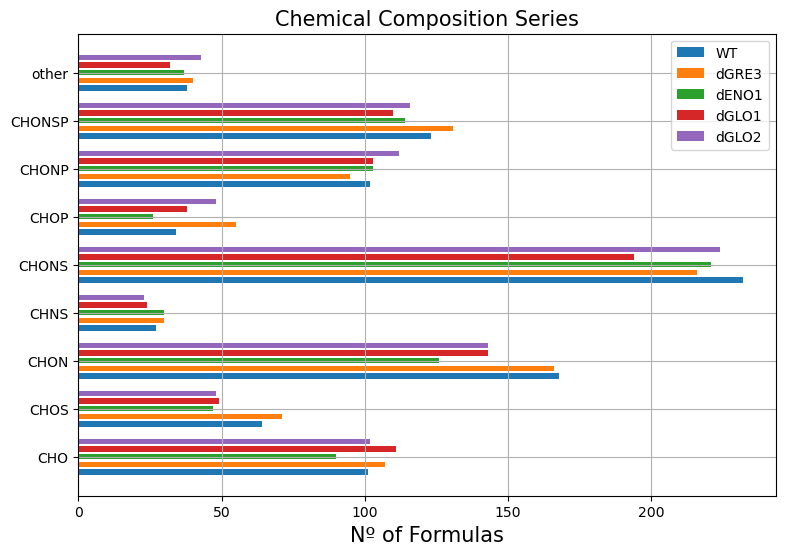

In [92]:
f, ax = plt.subplots(1,1, figsize=(9,6)) # Setting axes for the figs
chem_comp_series = plot_composition_series(group_dfs, ax=ax,label_colours=label_colours,)
plt.show()

In [93]:
chem_comp_series.T

,CHO,CHOS,CHON,CHNS,CHONS,CHOP,CHONP,CHONSP,other
WT,101,64,168,27,232,34,102,123,38
dGRE3,107,71,166,30,216,55,95,131,40
dENO1,90,47,126,30,221,26,103,114,37
dGLO1,111,49,143,24,194,38,103,110,32
dGLO2,102,48,143,23,224,48,112,116,43


# Step 8: BinSim Specific Analysis <a class="anchor" id="step-8"></a>

**Back to [Table of Contents](#toc)**

All analysis done very quickly using BinSim
- PCA
- HCA
- Random Forest
- PLS-DA

BinSim was performed as described in the BinSim paper as mentioned earlier.

PCA

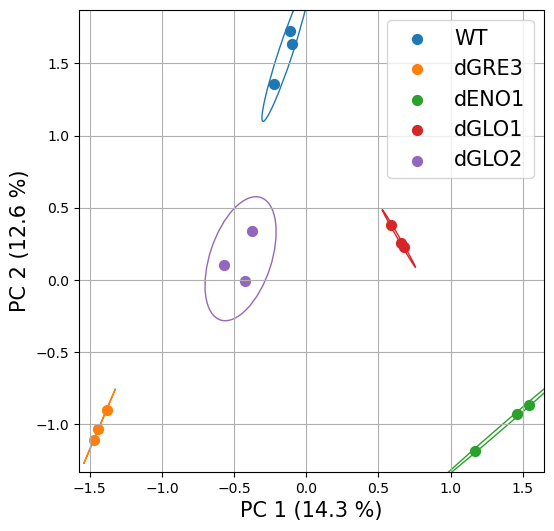

In [94]:
f, ax = plt.subplots(1, 1, figsize=(6,6)) # Change the size of the figure

principaldf_BinSim, var_BinSim = compute_df_with_PCs(bin_data, 
                                       n_components=2, # Select number of components to calculate
                                       whiten=True, labels=target, return_var_ratios=True)
# Plot PCA
ax.axis('equal')
lcolors = label_colours
plot_PCA(principaldf_BinSim, lcolors, 
         components=(1,2), # Select components to see
         title='', # Select title of plot
         ax=ax)

# Remove ellipses by putting a # before the next line
plot_ellipses_PCA(principaldf_BinSim, lcolors, 
                  components=(1,2), # Select components to see
                  ax=ax, 
                  q=0.95) # Confidence ellipse with 95% (q) confidence

ax.set_xlabel(f'PC 1 ({var_BinSim[0] * 100:.1f} %)', size=15) # Set the size of labels
ax.set_ylabel(f'PC 2 ({var_BinSim[1] * 100:.1f} %)', size=15) # Set the size of labels

plt.legend(fontsize=15) # Set the size of labels
plt.grid() # If you want a grid or not
plt.show()
#f.savefig('Name_BinSim_PCAplot.png', dpi=400) # Save the figure

HCA

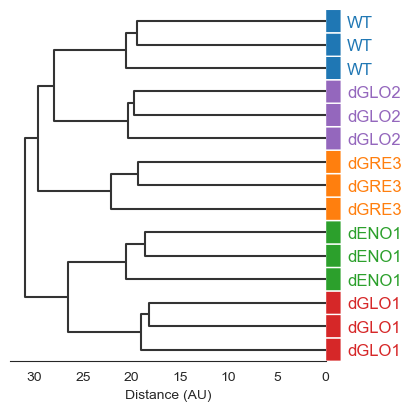

In [95]:
# Performing HCA 
metric = 'euclidean' # Select distance metric
method = 'ward' # Select linkage method

distances_BinSim = dist.pdist(bin_data, metric=metric)
Z_BinSim = hier.linkage(distances_BinSim, method=method)

hca_res_BinSim = {'Z': Z_BinSim, 'distances': distances_BinSim}

# Plot HCA
with sns.axes_style("white"):
    f, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True) # Set Figure Size
    plot_dendogram2(hca_res_BinSim['Z'], 
                   target, ax=ax,
                   label_colors=label_colours,
                   title='', # Select title
                   color_threshold=0) # Select a distance threshold from where different sets of lines are coloured

    plt.show()
    #f.savefig('Name_BinSim_HCAplot.png', dpi=400) # Save the figure

Random Forest

In [96]:
# Choose a number for the seed for consistent results
np.random.seed()

n_trees=200 # Number of trees in the model

RF_results_BinSim = metsta.RF_model(bin_data, target, # data and labels 
                      return_cv=True, iter_num=5, # if you want cross calidation results and number of iterations for it
                      n_trees=n_trees, # Number of trees in the model
                      cv=None, n_fold=3, # choose a method of cross-validation (None is stratified cv) and the number of folds
                metrics = ('accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted')) # Choose the performance metrics
results_summary_BinSim = pd.DataFrame(columns=['Value', 'Standard Deviation'])
for k,v in RF_results_BinSim.items():
    if k != 'model' and k != 'imp_feat':
        results_summary_BinSim.loc[k] = np.mean(v), np.std(v)

print(results_summary_BinSim)

imp_feats_rf_BinSim = meta_data.copy()
imp_feats_rf_BinSim.insert(0,'Bucket label', imp_feats_rf_BinSim.index)
imp_feats_rf_BinSim.insert(1,'Gini Importance', '')
imp_feats_rf_BinSim = imp_feats_rf_BinSim.copy()
for n in range(len(RF_results_BinSim['imp_feat'])):
    imp_feats_rf_BinSim['Gini Importance'].iloc[RF_results_BinSim['imp_feat'][n][0]] = RF_results_BinSim['imp_feat'][n][1]
imp_feats_rf_BinSim = imp_feats_rf_BinSim.sort_values(by='Gini Importance', ascending=False)
imp_feats_rf_BinSim.index = range(1, len(imp_feats_rf_BinSim)+1)

                    Value  Standard Deviation
accuracy              1.0                 0.0
f1_weighted           1.0                 0.0
precision_weighted    1.0                 0.0
recall_weighted       1.0                 0.0


C:\Users\franc\AppData\Local\Temp\ipykernel_17500\3673534620.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_rf_BinSim['Gini Importance'].iloc[RF_results_BinSim['imp_feat'][n][0]] = RF_results_BinSim['imp_feat'][n][1]


In [97]:
imp_feats_rf_BinSim.head(20)

,Bucket label,Gini Importance,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
1,343.5336148888 Da,0.003624,343.533615,344.540890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,692.4475624714 Da,0.003176,692.447562,693.454840,NaN,C35H60N6O8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,227.2249735476 Da,0.002982,227.224974,228.232250,NaN,C14H29NO,NaN,NaN,NaN,NaN,"[Q27273526, Q104946971, Q27893473, Q104916317,...","[Tetradecanamide, Xestoaminol A, n-Isobutyl de...","[C14H29NO, C14H29NO, C14H29NO, C14H29NO, C14H2...",6,NaN,NaN,NaN,NaN,True
4,356.2143252240 Da,0.002922,356.214325,357.221600,NaN,C11H24N12O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,555.2790351782 Da,0.002845,555.279035,556.286310,NaN,C19H57NO6S5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,556.2769642265 Da,0.002831,556.276964,557.284240,NaN,C24H49N2O6PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,257.9722002828 Da,0.002789,257.972200,258.979480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,415.8471892743 Da,0.002633,415.847189,416.854470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,700.6716564106 Da,0.002621,700.671656,723.660960,NaN,C28H80N18O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
10,770.6384724525 Da,0.002619,770.638472,771.645750,NaN,C37H94N4O5S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [98]:
# Saving Important feature dataset in an excel
SAVE_IMP_FEAT = False

# Saving the most important features by their fraction 'frac_feat_impor'.
# If None, saving the most important features based on a threshold 'VIP_Score_threshold'.
# If also None, save the full dataset of all features
frac_feat_impor = 0.02 # Fraction of features to save, If None the variable in the next line is used.
score_threshold = None # Only used if variable above is None, threshold of score to consider a feature important.

if SAVE_IMP_FEAT:
    if frac_feat_impor:
        max_idx = int(frac_feat_impor*len(imp_feats_rf_BinSim))
        filt_imp_feats_rf_BinSim = imp_feats_rf_BinSim.iloc[:max_idx]
        filt_imp_feats_rf_BinSim.to_excel(f'RF_BinSim_ImpFeat_{frac_feat_impor*100}%.xlsx')
    elif score_threshold:
        filt_imp_feats_rf_BinSim = imp_feats_rf_BinSim[imp_feats_rf_BinSim['Gini Importance'] > score_threshold]
        filt_imp_feats_rf_BinSim.to_excel(f'RF_BinSim_ImpFeat_GiniImpgreater{score_threshold}.xlsx')
    else:
        imp_feats_rf_BinSim.to_excel(f'RF_BinSim_FeatByImportance.xlsx')

In [99]:
#resROC_BinSim = metsta.RF_ROC_cv(bin_data, target, # Data and target
#                            '1', # Positive label
#                            n_trees=200, # Number of trees of RF
#                            n_iter=15, # Number of iterations to repeat 
#                            cv=None, n_fold=3) # method of cross-validation (None is stratified cv) and the number of folds

# Plot the ROC curves 
#with sns.axes_style("whitegrid"):
#    with sns.plotting_context("notebook", font_scale=1.2):
#        f, ax = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True)
#        res = resROC_BinSim
#        mean_fpr = res['average fpr']
#        mean_tpr = res['average tpr']
#        mean_auc = res['mean AUC']
#        mean_fpr = [0,] + list(mean_fpr)
#        mean_tpr = [0,] + list(mean_tpr)
#        ax.plot(mean_fpr, mean_tpr,
#               label=f'AUC = {mean_auc:.3f}',
#               lw=2, alpha=0.8)
#        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
#        ax.legend()
#        ax.set_xlim(None,1)
#        ax.set_ylim(0,None)
#        ax.set(xlabel='False positive rate', ylabel='True positive rate')

    #f.savefig(Name_BinSim_ROCcurve.jpg', dpi=400) # Save the figure

PLS-DA

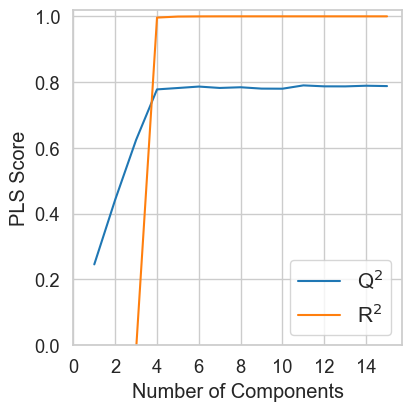

In [100]:
# Store Results
PLS_optim_BinSim = metsta.optim_PLSDA_n_components(bin_data, target, # Data and target
                                    encode2as1vector=True,
                                    max_comp=8, # Max. number of components to search (the higher the more time it takes)
                                    kf=None, n_fold=3, # Cross validation to use (none is stratified CV) and nº of folds
                                    scale=False) # Set scale to True only if you did not do scaling in pre-treatments

scores_cols = sns.color_palette('tab10', 10) # Set the colors for the lines
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(4,4), constrained_layout=True) # Set the figure size
        c = 0
        for i, values in PLS_optim.items():
            if i =='CVscores':
                name = 'Q$^2$'
            else:
                name = 'R$^2$'
            
            ax.plot(range(1, len(values) + 1), values, label=name, color = scores_cols[c])
            c = c+1
        
        ax.set(xlabel='Number of Components', # Set the label for the x axis
                ylabel='PLS Score') # Set the label for the Y axis
        ax.legend(loc='lower right', fontsize=15) # Set the legend
        ax.set_ylim([0, 1.02]) # Set limits for y axis
        ax.set_xticks(range(0, len(values), 2)) # Set ticks that appear in the bottom of x axis
        plt.show()

In [101]:
#%%capture --no-stdout
# above is to supress PLS warnings

n_comp = 4 # Number of components of PLS-DA model - very important

PLSDA_results_BinSim = metsta.PLSDA_model_CV(bin_data, target, # Data and target
                       n_comp=n_comp, # Number of components of PLS-DA model - very important
                       kf=None, n_fold=3, # Cross validation to use (none is stratified CV) and nº of folds
                       iter_num=10, # Number of iterations of cross-validation to do
                       encode2as1vector=True,
                       scale=False, # Set scale to True only if you did not do scaling in pre-treatments
                       feat_type='VIP') # Feature Importance Metric to use, default is VIP scores (see function for others)

results_summary_BinSim = pd.DataFrame(columns=['Value', 'Standard Deviation'])
for k,v in PLSDA_results_BinSim.items():
    if k != 'Q2' and k != 'imp_feat':
        results_summary_BinSim.loc[k] = np.mean(v), np.std(v)

print(results_summary_BinSim)

imp_feats_plsda_BinSim = meta_data.copy()
imp_feats_plsda_BinSim.insert(0,'Bucket label', imp_feats_plsda_BinSim.index)
imp_feats_plsda_BinSim.insert(1,'VIP Score', '')
for n in range(len(PLSDA_results_BinSim['imp_feat'])):
    imp_feats_plsda_BinSim['VIP Score'][PLSDA_results_BinSim['imp_feat'][n][0]] = PLSDA_results_BinSim['imp_feat'][n][1]
imp_feats_plsda_BinSim = imp_feats_plsda_BinSim.sort_values(by='VIP Score', ascending=False)
imp_feats_plsda_BinSim.index = range(1, len(imp_feats_plsda_BinSim)+1)

imp_feats_plsda_BinSim.head(20) # Select number of features to see

           Value  Standard Deviation
accuracy     1.0                 0.0
F1-scores    1.0                 0.0
precision    1.0                 0.0
recall       1.0                 0.0


C:\Users\franc\AppData\Local\Temp\ipykernel_17500\916925773.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_feats_plsda_BinSim['VIP Score'][PLSDA_results_BinSim['imp_feat'][n][0]] = PLSDA_results_BinSim['imp_feat'][n][1]


,Bucket label,VIP Score,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,Matched LTS formulas,LTS match count,Matched DBK IDs,Matched DBK names,Matched DBK formulas,DBK match count,Has Match?
1,257.2718866583 Da,1.943258,257.271887,258.27916,NaN,C16H35NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,378.2307302106 Da,1.839191,378.230730,379.23801,Doxapram,C24H30N2O2,[HMDB0014701],[Doxapram],[C24H30N2O2],1,NaN,NaN,NaN,NaN,[DBK00449],[Doxapram],[C24H30N2O2],1,True
3,401.8679407462 Da,1.839191,401.867941,402.87522,NaN,C10H2N4O4S5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,458.2814201455 Da,1.829974,458.281420,459.28874,NaN,C23H42N2O5S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,230.0102363015 Da,1.829974,230.010236,231.01751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,224.0632478938 Da,1.829974,224.063248,225.07052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,414.1389151466 Da,1.829974,414.138915,415.14619,NaN,C11H19N12O4P,NaN,NaN,NaN,NaN,"[Q27106178, Q105248825]","[Clavamycin A, (2S,3R)-2-[[(2S,3S)-2-amino-3-h...","[C16H22N4O9, C16H22N4O9]",2,NaN,NaN,NaN,NaN,True
8,200.2930225885 Da,1.829974,200.293023,201.30030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,370.1059521707 Da,1.829974,370.105952,371.11323,NaN,C13H18N6O5S,NaN,NaN,NaN,NaN,[Q82192722],"[2-Amino-3-[[5-(6-aminopurin-9-yl)-3,4-dihydro...",[C13H18N6O5S],1,NaN,NaN,NaN,NaN,True
10,319.0184694573 Da,1.829974,319.018469,320.02575,NaN,C11H13NO6S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [102]:
# Saving Important feature dataset in an excel
SAVE_IMP_FEAT = False

# Saving the most important features by their fraction 'frac_feat_impor'.
# If None, saving the most important features based on a threshold 'VIP_Score_threshold'.
# If also None, save the full dataset of all features
frac_feat_impor = 0.02 # Fraction of features to save, If None the variable in the next line is used.
VIP_Score_threshold = 1 # Only used if variable above is None, threshold of score to consider a feature important.

if SAVE_IMP_FEAT:
    if frac_feat_impor:
        max_idx = int(frac_feat_impor*len(imp_feats_plsda_BinSim))
        filt_imp_feats_plsda_BinSim = imp_feats_plsda_BinSim.iloc[:max_idx]
        filt_imp_feats_plsda_BinSim.to_excel(f'PLSDA_BinSim_ImpFeat_{frac_feat_impor*100}%.xlsx')
    elif VIP_Score_threshold:
        filt_imp_feats_plsda_BinSim = imp_feats_plsda_BinSim[imp_feats_plsda_BinSim['VIP Score'] > VIP_Score_threshold]
        filt_imp_feats_plsda_BinSim.to_excel(f'PLSDA_BinSim_ImpFeat_VIPgreater{VIP_Score_threshold}.xlsx')
    else:
        imp_feats_plsda_BinSim.to_excel(f'PLSDA_BinSim_FeatByImportance.xlsx')

# Step 9: Find Specific Compounds <a class="anchor" id="step-9"></a>

**Back to [Table of Contents](#toc)**

This code will allow you to conveniently find specific compounds by their name, formula, m/z or neutral mass. The mass finders work even if you don't know the specific mass, as you can search only by the first few digits.

In [103]:
id_type = 'name' #pick 'formula', 'name', 'neutral mass' or 'm/z'
find_id = 'Palmitic acid'
if id_type == 'neutral mass':
    finder = processed_data.loc[processed_data.index.str.startswith(find_id)]
if id_type == 'm/z':
    processed_data.loc[processed_data['m/z'].astype('str').str.startswith(find_id)]
if id_type == 'formula':
    index_list = []
    for col in meta_cols_formulas:
        temp_df = processed_data[[col]].dropna()
        for t in temp_df.index:
            if find_id in temp_df[col][t]:
                index_list.append(t)
    finder = processed_data.loc[processed_data.index.isin(index_list)]
if id_type == 'name':
    index_list = []
    for col in meta_cols_names:
        temp_df = processed_data[[col]].dropna()
        for t in temp_df.index:
            if find_id in temp_df[col][t]:
                index_list.append(t)
    finder = processed_data.loc[processed_data.index.isin(index_list)]
finder

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,...,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,,,,
256.2402073027 Da,256.240207,257.24756,2-hydroxyhexadecanal,C16H32O2,"[HMDB0000220, HMDB0002396, HMDB0031068, HMDB00...","[Palmitic acid, Trimethyltridecanoic acid, Iso...","[C16H32O2, C16H32O2, C16H32O2, C16H32O2, C16H3...",11,"[Q63399983, Q27253736, Q27158117, Q82863912, Q...","[Isobutyl laurate, Butyl laurate, Ethyl tetrad...",...,0.117235,0.094022,0.1193,0.131663,0.087703,0.092348,0.096286,0.032826,0.030327,0.031342


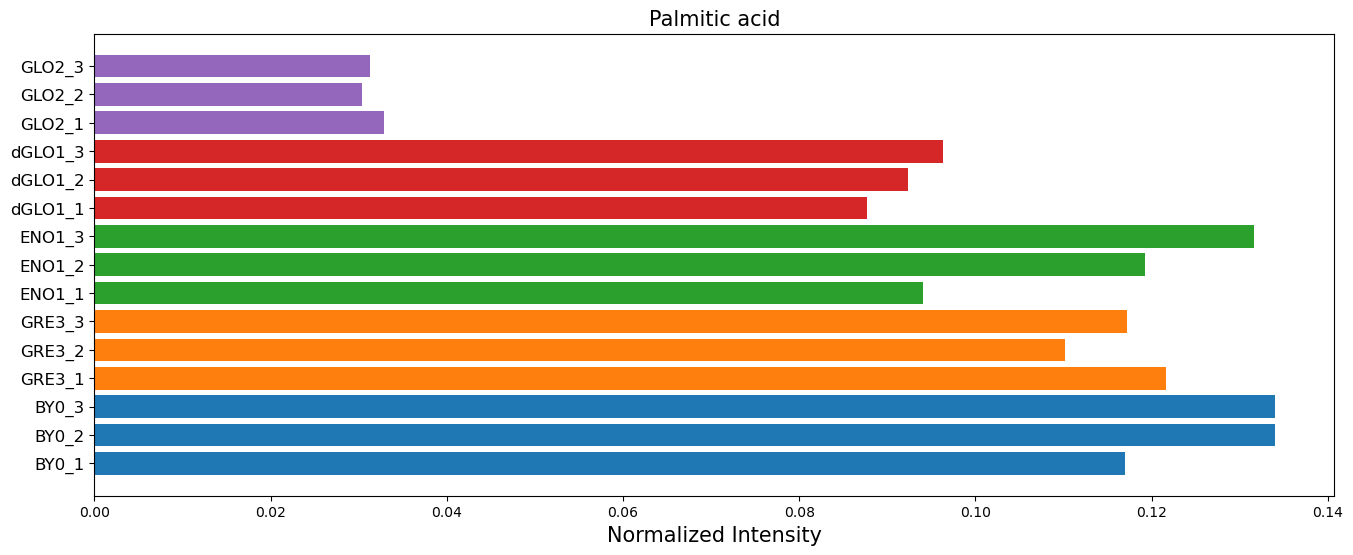

In [104]:
# Plot to see the intensities distribution (might become difficult to see with a lot of samples)
bar_plot_info = finder.replace({np.nan:0})
if len(bar_plot_info.index) == 1:
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    x = np.arange(len(bar_plot_info.columns[-len(sample_cols):]))
    for comps in range(len(bar_plot_info.index)):
        ax.barh(x, np.array(bar_plot_info.iloc[comps, -len(sample_cols):]), color=sample_colours)
        ax.set_xlabel('Normalized Intensity', fontsize=15)
        ax.set_title(find_id, fontsize=15)
else:
    fig, axs = plt.subplots(1,len(bar_plot_info.index), figsize=(16,6))

    x = np.arange(len(bar_plot_info.columns[-len(sample_cols):]))
    for (comps, ax) in zip(range(len(bar_plot_info.index)), axs.ravel()):
        ax.barh(x, np.array(bar_plot_info.iloc[comps, -len(sample_cols):]), color=sample_colours)
        ax.set_yticks([])
        #ax.tick_params(labelleft=False)
        ax.set_xlabel('Normalized Intensity', fontsize=13)
        ax.set_title(find_id)
    ax = axs[0]
ax.set_yticks(x)
ax.set_yticklabels(bar_plot_info.columns[-len(sample_cols):], fontsize=12)
plt.show()

Search for the differences between groups

In [105]:
# Calculate average intensities
gfinder = finder.copy()
for g in groups:
    gfinder[g+' Average'] = gfinder[gfinder.columns.intersection(groups[g])].mean(axis=1)
    gfinder[g+' std'] = gfinder[gfinder.columns.intersection(groups[g])].std(axis=1)
gfinder

,Neutral Mass,m/z,Name,Formula,Matched HMDB IDs,Matched HMDB names,Matched HMDB formulas,HMDB match count,Matched LTS IDs,Matched LTS names,...,WT Average,WT std,dGRE3 Average,dGRE3 std,dENO1 Average,dENO1 std,dGLO1 Average,dGLO1 std,dGLO2 Average,dGLO2 std
Bucket label,,,,,,,,,,,,,,,,,,,,,
256.2402073027 Da,256.240207,257.24756,2-hydroxyhexadecanal,C16H32O2,"[HMDB0000220, HMDB0002396, HMDB0031068, HMDB00...","[Palmitic acid, Trimethyltridecanoic acid, Iso...","[C16H32O2, C16H32O2, C16H32O2, C16H32O2, C16H3...",11,"[Q63399983, Q27253736, Q27158117, Q82863912, Q...","[Isobutyl laurate, Butyl laurate, Ethyl tetrad...",...,0.128361,0.009804,0.116351,0.005839,0.114995,0.019186,0.092112,0.004297,0.031498,0.001257


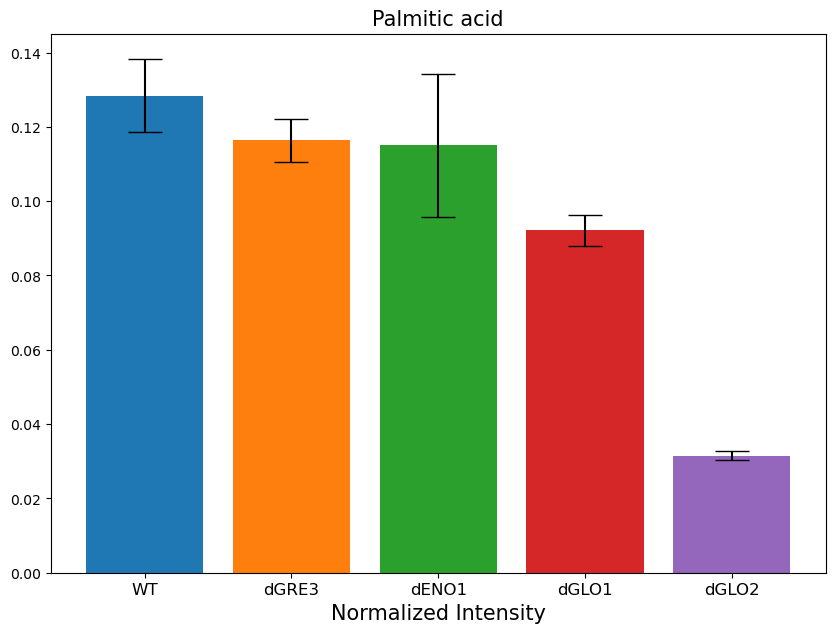

In [106]:
avg_cols = [col for col in gfinder.columns if 'Average' in col]
std_cols = [col for col in gfinder.columns if 'std' in col]
group_colours = [label_colours[lbl] for lbl in classes]
bar_plot_info = gfinder.replace({np.nan:0})
if len(bar_plot_info.index) == 1:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    x = np.arange(len(avg_cols))
    for comps in bar_plot_info.index:
        ax.bar(x, np.array(bar_plot_info.loc[comps, avg_cols]), color=group_colours, yerr=np.array(bar_plot_info.loc[comps, std_cols]), capsize=12)
        ax.set_xlabel('Normalized Intensity', fontsize=15)
        ax.set_title(find_id, fontsize=15)
        ax.set_xticks(x)
        ax.set_xticklabels(groups, fontsize=12)
else:
    fig, axs = plt.subplots(1,len(bar_plot_info.index), figsize=(16,6))

    x = np.arange(len(avg_cols))
    for (comps, ax) in zip(bar_plot_info.index, axs.ravel()):
        ax.bar(x, np.array(bar_plot_info.loc[comps, avg_cols]), color=group_colours, yerr=np.array(bar_plot_info.loc[comps, std_cols]), capsize=12)
        ax.set_yticks([])
        #ax.tick_params(labelleft=False)
        ax.set_xlabel('Normalized Intensity', fontsize=13)
        ax.set_title(find_id)
        ax.set_xticks(x)
        ax.set_xticklabels(groups)
    ax = axs[0]
plt.show()

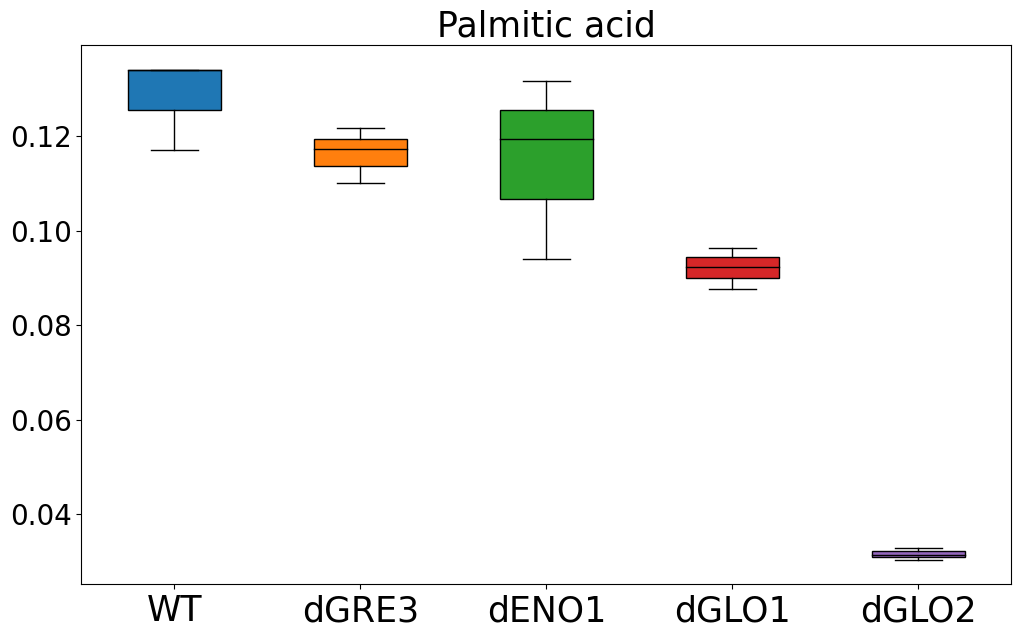

In [107]:
if len(finder.index) == 1:
    its_list = []
    for g in groups:
        its = finder[finder.columns.intersection(groups[g])].T.reset_index(drop= True)
        its_list.append(its)
    its_df = pd.concat(its_list, axis=1)
    its_df = its_df.set_axis(groups, axis=1)
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    box1= ax.boxplot(its_df, labels=its_df.columns, patch_artist=True, medianprops=dict(color='black'))
    for patch, color, lbl in zip(box1['boxes'], colours, its_df.columns):
        patch.set_facecolor(color)
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_title(find_id, fontsize=25)
    plt.show()
else:
    fig, axs = plt.subplots(1,len(finder.index), figsize=(16,6))
    for (comps, ax) in zip(finder.index, axs.ravel()):
        comps_df = finder.loc[[comps]]
        its_list = []
        for g in groups:
            its = comps_df[comps_df.columns.intersection(groups[g])].T.reset_index(drop= True)
            its_list.append(its)
        its_df = pd.concat(its_list, axis=1)
        its_df = its_df.set_axis(groups, axis=1)
        box1= ax.boxplot(its_df, labels=its_df.columns, patch_artist=True, medianprops=dict(color='black'))
        for patch, color, lbl in zip(box1['boxes'], colours, its_df.columns):
            patch.set_facecolor(color)
        ax.set_title(find_id, fontsize=15)
    ax = axs[0]
plt.show()

### Notebook made by:

- FT-ICR-MS-Lisboa Laboratory Group